경로 확인 완료 실행 확인 불가

# 영화/드라마 흥행 예측 모델링 (흥행 라벨링 상위20% vs 하위40% vs 중간40%(제거) + 임베딩 모델 qwen3로 변경)

## 모델 비교
- LightGBM
  - 개요: 데이터를 가장 잘 나누는 질문을 빠르게 반복하며 흥행 여부를 판단하는 모델
  - 장점
    - 고차원·희소 피처 처리에 특화 → BERT 임베딩, TF-IDF, 배우 임베딩 모두에 강함
    - RandomForest보다 훨씬 빠르고, XGBoost보다도 가벼움
    - 정확도도 일반적으로 XGBoost와 거의 동급
    - 하이퍼파라미터 기본값도 꽤 안정적
    - 카테고리 인코딩도 자동 지원
  - 단점
    - 데이터가 극단적으로 작은 경우에는 과적합 위험이 있으나, 본 분석 규모에서는 문제가 되지 않음
- XGBoost
  - 개요: 틀린 예측에 더 집중해가며 이전 모델의 실수를 보완하는 트리 앙상블 모델
  - 장점
    - 전통적으로 성능이 매우 좋음
    - 예측 정확도 탑 클래스
  - 단점
    - 훈련 속도 느림
    - 고차원 피처에 메모리 폭발하기 쉬움
    - 파라미터 복잡 (튜닝 난이도 ↑)
    - 대규모·고차원 데이터에서는 GPU 활용이 사실상 필요함
- MLP (Multi-Layer Perceptron Classifier, 다층 퍼셉트론 분류기)
  - 개요: 인공신경망(Neural Network) 기반 분류 모델
  - 장점
    - 고차원 연속 피처(텍스트 임베딩) 표현 학습 능력이 뛰어남
    - 비선형 패턴을 잘 학습함
    - 충분한 데이터가 있을 경우 성능 잠재력 큼
  - 단점
    - 스케일링 필수, 전처리 의존도 높음
    - 학습 불안정(초기값·러닝레이트·구조 민감)
    - Feature Importance 해석이 어려움
    - 트리 모델 대비 성능 대비 설명력·안정성이 떨어짐
- RandomForest → 성능 한계가 명확해 뜨는 모델에 미치지 못함 (제외)
  - 개요: 서로 다른 많은 결정나무의 투표로 흥행 여부를 결정하는 안정적인 평균 모델
  - 장점
    - 구현 쉽고 안정적
    - 과적합에 강함
    - 직관적
  - 단점
    - 고차원·희소 벡터(텍스트 임베딩) 처리에 약함
    - 훈련 속도 느림
    - 성능 천장이 빨리 온다
→ LightGBM을 우선적으로, XGBoost, MLP 시도해 보기!


## 모델링 절차

#### (1) 피처 선택
- 영화 데이터
  - movie_main : original_language, release_date, runtime
  - movie_genre : genre
  - movie_country : production_countries
  - movie_emb : overview + genre
  - hit_score : hit_score
- 드라마 데이터
  - drama_main : original_language, first_air_date (데이터 누수 방지를 위해 첫 방영 시점의 계절성만 보고, 시대 효과는 제거)
  - drama_genre : genre
  - drama_country : production_countries
  - drama_emb : overview + genre
  - hit_score : hit_score

#### (2) 피처 엔지니어링
- 타겟(y) 생성: 흥행점수 기준 흥행(상위20%=1) vs 비흥행(하위40%=0) vs 중간(40%=제거)
- genre : 멀티 라벨 인코딩
- release_date / first_air_date : month 변환 → 순환 인코딩
- country : 이미 상위 10개국 + other 전처리 되어 있음 → 바로 원핫 인코딩
- language : 원핫 인코딩
- overview + genre : 텍스트 임베딩 (1024차원 그대로 사용) 
- hit_score : 흥행 라벨 생성 후 병합 (데이터 누수 방지)
- Feature Table 병합: 누수 방지 피처(hit_score 등)는 절대 넣지 말기
- 결측치 처리

#### (3) 모델 학습 (LightGBM, XGBoost, MLP)
- 영화/드라마가 상위 20% 흥행 그룹에 속할 확률(P(hit))을 0~1 범위로 예측하는 이진 분류 모델을 구축
- 트리 기반 모델인 LightGBM과 XGBoost를 활용하여 모델 구조 차이에 따른 예측 성능의 안정성과 feature 중요도 해석의 일관성을 비교·검증
- MLP(신경망) 모델을 추가하여 트리 기반 모델과 대비되는 비선형 패턴 학습 능력 및 텍스트 임베딩 활용 효과를 분석
- 3개 모델을 하나의 앙상블 모델로 결합하여 인사이트 도출
- 사용 모델: LightGBM, XGBoost, MLP, 앙상블

## 예측 모델링 (영화)

### 환경 세팅

In [1]:
import pandas as pd
import numpy as np
import ast
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, classification_report, roc_curve)
import shap
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
import platform
if platform.system() == 'Windows': # Windows OS
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # mac OS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'
mpl.rc('axes', unicode_minus=False) # 축의 음수 부호를 깨지지 않게 설정

# 실험 재현성을 위한 랜덤 시드 고정
RANDOM_STATE = 42

### 영화 데이터 전처리 및 피처 엔지니어링

#### (1) 데이터 로드+ 통합 중복 제거

In [2]:
# 영화 데이터 로드+ 통합 중복 제거

movie_main = pd.read_parquet('files/movie/00_movie_main.parquet').drop_duplicates("imdb_id")
movie_genre = pd.read_parquet('files/movie/02_movie_genre.parquet') # groupby로 중복 처리
movie_country = pd.read_parquet('files/movie/04_movie_country.parquet') # groupby로 중복 처리
movie_emb  = pd.read_parquet('files/movie/09_movie_text_embedding.parquet').drop_duplicates("imdb_id")
hit_score = pd.read_parquet('files/movie/09_hit_score.parquet').drop_duplicates("imdb_id", keep='last')

#### (2) movie_main: 방영 월 순환 인코딩 + 언어 원핫

In [3]:
# movie_main_cleaned: 개봉월 순환 인코딩 + 언어 원핫 + runtime
movie_main_cleaned = movie_main[["imdb_id", "original_language", "release_date", "runtime"]].copy()

# release_date → month 변환 → 순환 인코딩
movie_main_cleaned["release_date"] = pd.to_datetime(movie_main_cleaned["release_date"], errors="coerce")
movie_main_cleaned["release_month"] = movie_main_cleaned["release_date"].dt.month

movie_m = movie_main_cleaned["release_month"].fillna(0)
movie_main_cleaned["month_sin"] = np.where(movie_m > 0, np.sin(2*np.pi*movie_m/12), 0.0)
movie_main_cleaned["month_cos"] = np.where(movie_m > 0, np.cos(2*np.pi*movie_m/12), 0.0)

movie_main_cleaned = movie_main_cleaned.drop(columns=["release_date", "release_month"])

# original_language 원핫 인코딩
movie_main_cleaned["original_language"] = movie_main_cleaned["original_language"].fillna("unk") # fillna("unk") = 값이 없을 때 NaN이 아니라 "정보 없음" 상태가 필요
movie_main_cleaned = pd.get_dummies(movie_main_cleaned, columns=["original_language"], drop_first=True)
movie_main_cleaned


,imdb_id,runtime,month_sin,month_cos,original_language_en,original_language_es,original_language_fr,original_language_hi,original_language_it,original_language_ja,original_language_ko,original_language_ru,original_language_xx,original_language_zh
0,tt0384699,102,0.5,0.866025,True,False,False,False,False,False,False,False,False,False
1,tt0444346,83,0.5,0.866025,False,True,False,False,False,False,False,False,False,False
2,tt0360016,90,0.5,0.866025,True,False,False,False,False,False,False,False,False,False
3,tt0398378,84,0.5,0.866025,True,False,False,False,False,False,False,False,False,False
4,tt0443590,70,0.5,0.866025,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,tt33053440,99,-0.5,0.866025,True,False,False,False,False,False,False,False,False,False
26967,tt19847976,137,-0.5,0.866025,True,False,False,False,False,False,False,False,False,False
26968,tt34794183,115,-0.5,0.866025,False,False,True,False,False,False,False,False,False,False
26969,tt24852126,96,-0.5,0.866025,True,False,False,False,False,False,False,False,False,False


#### (3) movie_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)

In [4]:
# movie_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)
movie_genre_list = movie_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

movie_mlb = MultiLabelBinarizer()
movie_genre_ohe = movie_mlb.fit_transform(movie_genre_list["genre"])

movie_genre_ohe = pd.DataFrame(movie_genre_ohe, columns=[f"genre_{g}" for g in movie_mlb.classes_])
movie_genre_ohe["imdb_id"] = movie_genre_list["imdb_id"].values
movie_genre_ohe

,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_War,genre_Western,imdb_id
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,tt0069049
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,tt0082328
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,tt0093119
3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,tt0120667
4,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,tt0121164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tt9908390
26967,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,tt9911196
26968,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tt9914192
26969,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,tt9916270


#### (4) movie_country: 원핫 인코딩

In [5]:
# movie_country: 이미 상위10 + other 전처리 → 바로 원핫 인코딩
movie_country = movie_country[["imdb_id", "production_countries"]].copy()

movie_country_ohe = pd.get_dummies(
    movie_country,
    columns=["production_countries"],
    prefix="country",
    drop_first=True
)

movie_country_ohe = movie_country_ohe.groupby("imdb_id", as_index=False).sum()
movie_country_ohe

,imdb_id,country_canada,country_france,country_germany,country_india,country_italy,country_japan,country_other,country_spain,country_united kingdom,country_united states of america
0,tt0069049,0,1,0,0,0,0,1,0,0,1
1,tt0082328,0,0,0,0,0,0,1,0,0,0
2,tt0093119,0,0,0,0,0,0,0,0,0,1
3,tt0120667,0,0,1,0,0,0,0,0,0,1
4,tt0121164,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
26567,tt9908390,0,1,0,0,0,0,0,0,0,0
26568,tt9911196,0,0,0,0,0,0,1,0,0,0
26569,tt9914192,0,0,0,0,0,0,1,0,0,0
26570,tt9916270,0,0,0,0,1,0,0,0,0,0


#### (5) overview + genre 텍스트 임베딩 전처리

In [6]:
# 영화 줄거리 + 장르 텍스트 임베딩 전처리 (1024차원)
movie_emb = movie_emb[['imdb_id', 'embedding']].drop_duplicates("imdb_id")

# 문자열인 경우 리스트로 변환
def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

movie_emb["embedding"] = movie_emb["embedding"].apply(to_list)

# 1024개 컬럼으로 펼치기
movie_emb_df = pd.DataFrame(
    movie_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

movie_emb_final = pd.concat([
    movie_emb[['imdb_id']].reset_index(drop=True),
    movie_emb_df
], axis=1)

print(f"Movie 임베딩 컬럼: {movie_emb_final.shape[1] - 1}개")  # 1024개 출력됨
movie_emb_final

Movie 임베딩 컬럼: 1024개


,imdb_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,tt0384699,0.025793,-0.029124,-0.012145,0.040179,0.061450,-0.083330,-0.034874,-0.008542,-0.005748,...,-0.021020,-0.001709,-0.039366,0.012469,-0.016855,0.008091,0.002347,0.014278,0.028139,-0.013321
1,tt0444346,-0.012859,-0.044328,-0.012216,0.093285,0.097620,-0.080092,0.049314,0.036666,0.013957,...,-0.011279,0.002140,0.006924,0.011912,-0.030447,0.000379,-0.012910,-0.012974,0.015264,0.002797
2,tt0360016,0.028820,-0.075382,-0.008895,0.002542,0.120405,-0.062174,-0.014535,0.003471,0.009074,...,-0.034509,-0.006777,-0.016874,0.020836,-0.022622,-0.043964,-0.026676,-0.016504,-0.007148,-0.006156
3,tt0398378,0.046757,-0.041634,-0.008595,-0.006625,0.055931,-0.009548,-0.036248,0.019832,0.109671,...,-0.015676,0.003657,-0.018058,-0.062707,-0.014812,-0.017490,0.010513,-0.009887,0.021049,-0.011648
4,tt0443590,0.056878,-0.033675,-0.010737,0.022414,0.069207,-0.038936,-0.020371,0.081370,0.056799,...,-0.059918,-0.012645,0.021103,0.005409,-0.026837,-0.012537,-0.005937,-0.017221,0.015622,-0.054349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26966,tt33053440,-0.010183,-0.012093,-0.009894,0.020575,0.037580,-0.080423,0.009604,0.023855,-0.006830,...,-0.021952,-0.016373,0.031010,-0.007726,-0.059872,-0.019717,-0.014097,0.001049,-0.037527,-0.012783
26967,tt19847976,0.039958,-0.000482,-0.013137,-0.009626,0.075064,-0.042355,0.034210,0.008805,0.052500,...,0.003531,-0.006885,0.041081,-0.019564,-0.011624,-0.009231,-0.026906,-0.011831,-0.000504,-0.008561
26968,tt34794183,0.090418,-0.093043,-0.004208,0.060368,0.018771,-0.008531,-0.016960,-0.027696,0.004272,...,-0.056528,0.022517,-0.066956,-0.039421,-0.026590,0.004688,0.009013,-0.014235,0.056374,-0.004579
26969,tt24852126,0.013242,-0.052644,-0.008363,0.011981,0.028595,-0.071660,-0.041961,-0.032133,0.029569,...,-0.034947,-0.018484,0.016396,-0.049316,-0.028547,-0.000672,-0.019171,-0.018576,-0.031930,-0.009832


#### (6) Feature Table 병합

In [7]:
# Feature Table 병합
print(f"Movie Feature Table 병합 전: {movie_main_cleaned.shape}")

# 전처리한 피처 병합
movie_merged = (
    movie_main_cleaned.copy()
    .merge(movie_genre_ohe, on="imdb_id", how="left")
    .merge(movie_country_ohe, on="imdb_id", how="left")
    .merge(movie_emb_final, on="imdb_id", how="left")
    .merge(hit_score[["imdb_id", "hit_score"]], on="imdb_id", how="inner")
)

print(f"Movie Feature Table 병합 후: {movie_merged.shape}")

Movie Feature Table 병합 전: (26971, 14)
Movie Feature Table 병합 후: (26061, 1068)


#### (7) 타겟(y) 생성: 흥행 라벨링 (상위20% = 1, 하위40% = 0, 중간40% 제거)

In [8]:
# 타겟(y) 생성: 상위20% = 1, 하위40% = 0, 중간40% 제거
q80 = movie_merged["hit_score"].quantile(0.8)  # 상위 20% 기준
q40 = movie_merged["hit_score"].quantile(0.4)  # 하위 40% 기준

movie_merged["y"] = np.where(
    movie_merged["hit_score"] >= q80, 1,           # 상위 20%
    np.where(movie_merged["hit_score"] <= q40, 0,  # 하위 40%
             np.nan)                               # 중간 40% (제거)
)

movie_merged = movie_merged.dropna(subset=["y"])
movie_merged["y"] = movie_merged["y"].astype(int)
movie_merged = movie_merged.drop(columns=["hit_score"]) # hit_score 제거 (데이터 누수 방지)

print(f"라벨링 후 (상위20%=1, 하위40%=0, 중간 40%=제거): {movie_merged.shape}")
print(f"Movie Label 분포:")
print(movie_merged["y"].value_counts(normalize=True))

라벨링 후 (상위20%=1, 하위40%=0, 중간 40%=제거): (15638, 1068)
Movie Label 분포:
y
0    0.666645
1    0.333355
Name: proportion, dtype: float64


#### (8) 병합 테이블 결측치 처리

In [9]:
# 결측치 처리 (변수 타입별로 다르게)

# 1) 원-핫 인코딩 변수: 결측치 0으로 채우기
movie_dummy_prefixes = ('genre_', 'country_', 'original_language_')
movie_dummy_cols = [c for c in movie_merged.columns if c.startswith(movie_dummy_prefixes)] 
movie_merged[movie_dummy_cols] = movie_merged[movie_dummy_cols].fillna(0)

# 2) 임베딩: 결측치 0으로 채우기 + missing flag 생성
movie_emb_cols = [c for c in movie_merged.columns if c.startswith("emb_")] # "emb_"로 시작하는 컬럼들만 새 리스트로 추출
movie_merged["embedding_missing"] = movie_merged[movie_emb_cols].isnull().all(axis=1).astype(int)
movie_merged[movie_emb_cols] = movie_merged[movie_emb_cols].fillna(0)

# 3) runtime: 결측치 0으로 채우기 + missing flag 생성
if 'runtime' in movie_merged.columns:
    movie_merged["runtime_missing"] = movie_merged["runtime"].isna().astype(int)
    movie_merged["runtime"] = movie_merged["runtime"].fillna(0)

# 4) 마지막 남은 결측치 안전하게 처리
movie_remaining_nulls = movie_merged.isnull().sum()
if movie_remaining_nulls.sum() > 0:
    print(f"\n⚠️ 남은 결측치:\n{movie_remaining_nulls[movie_remaining_nulls > 0]}")
    movie_merged = movie_merged.fillna(0)

print("결측치 처리 완료")
print(f"Movie Final Feature Table Shape: {movie_merged.shape}")
print(f"Movie Label balance: {movie_merged['y'].value_counts(normalize=True).to_dict()}")

결측치 처리 완료
Movie Final Feature Table Shape: (15638, 1070)
Movie Label balance: {0: 0.6666453510679115, 1: 0.3333546489320885}


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


#### (9) Train/Valid Split

In [10]:
# Movie Train/Valid Split
movie_X = movie_merged.drop(columns=["imdb_id", "y"])
movie_y = movie_merged["y"].values

movie_X_train, movie_X_valid, movie_y_train, movie_y_valid = train_test_split(
    movie_X, movie_y, test_size=0.2, stratify=movie_y, random_state=RANDOM_STATE
)

print(f"\nMovie Train: {movie_X_train.shape}, Movie Valid: {movie_X_valid.shape}")
print(f"Movie Train label 분포: {np.bincount(movie_y_train)}")
print(f"Movie Valid label 분포: {np.bincount(movie_y_valid)}")


Movie Train: (12510, 1068), Movie Valid: (3128, 1068)
Movie Train label 분포: [8340 4170]
Movie Valid label 분포: [2085 1043]


### 영화 흥행 예측 모델 (LightGBM) 

영화 흥행 예측 모델 LightGBM (상위20% vs 하위40%)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4170, number of negative: 8340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261367
[LightGBM] [Info] Number of data points in the train set: 12510, number of used features: 1066
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.838054	valid_0's binary_logloss: 0.490302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	val

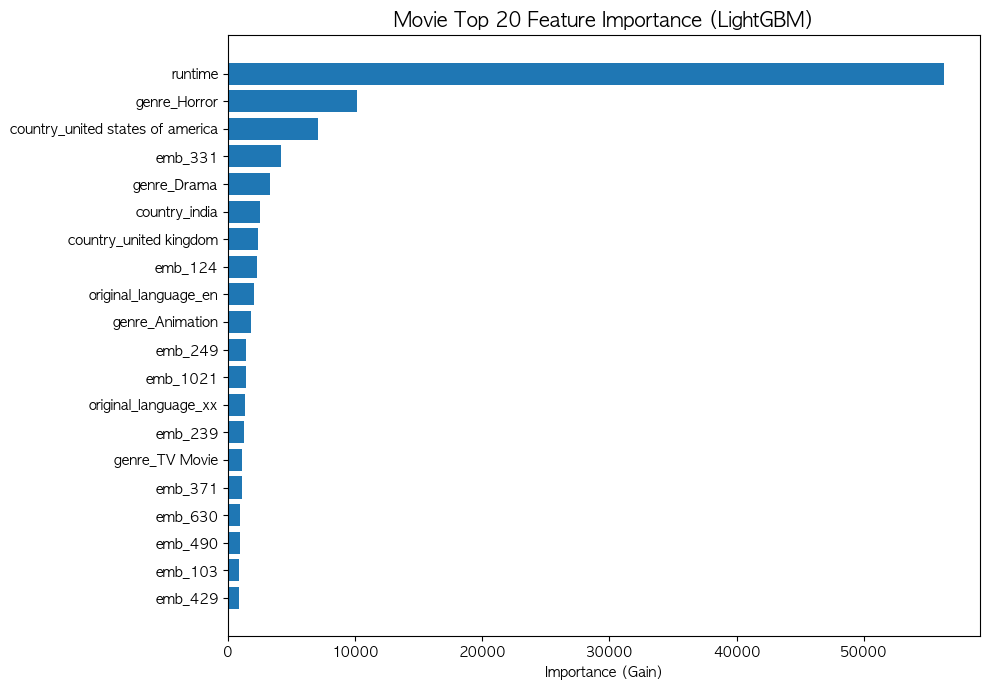

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


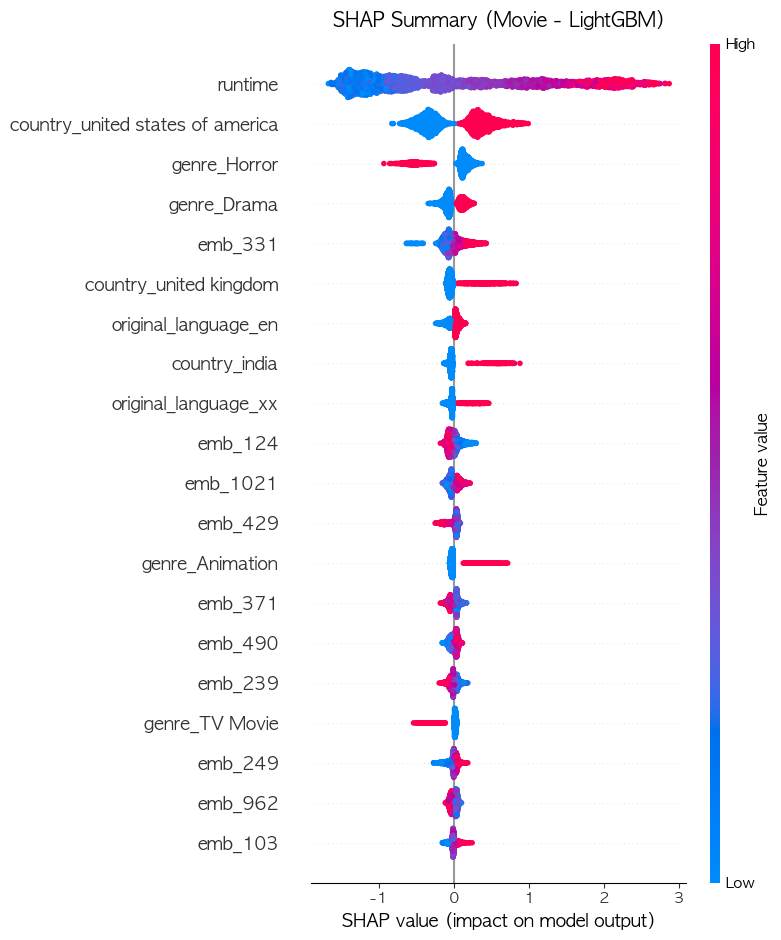

In [11]:
# ============================================================
# 영화 흥행 예측 모델 (LightGBM)
# ============================================================

print("="*60)
print("영화 흥행 예측 모델 LightGBM (상위20% vs 하위40%)")
print("="*60)

# ============================================================
# LightGBM 학습
# ============================================================
movie_lgb_model = lgb.LGBMClassifier(
    objective="binary",                 # 이진분류 문제 (흥행1/비흥행0)
    n_estimators=5000,                  # 최대 트리 수 (early_stopping으로 자동 조정)
    learning_rate=0.025,                 # 학습 속도 (작을수록 천천히 정확히 학습)
    num_leaves=63,                      # 한 트리당 최대 리프 수 (복잡도 제어)
    min_child_samples=35,               # 리프 최소 샘플 수 (과적합 방지)
    subsample=0.85,                      # 데이터 무작위 사용 비율 (샘플링)
    colsample_bytree=0.85,               # 피처 무작위 사용 비율 (피처 샘플링)
    reg_lambda=1.2,                     # L2 정규화 (과적합 방지)
    reg_alpha=0.2,                      # 약한 L1 추가
    max_depth=8,                        # 깊이 제한
    class_weight='balanced',            # 클래스 비율에 따라 자동 클래스 가중치 적용 (소수 클래스(흥행) 학습 비중 강화)
    random_state=RANDOM_STATE,          # 랜덤 시드 고정 (매 실행마다 똑같은 결과 보장)
    n_jobs=-1,                          # 모든 CPU 코어 병렬 사용 (트리 학습 시 최대 속도)
)

movie_lgb_model.fit(
    movie_X_train, movie_y_train,                   # 학습 데이터
    eval_set=[(movie_X_valid, movie_y_valid)],      # 검증 데이터 (학습 중 성능 체크용)
    eval_metric="auc",                  # 평가 지표 (Valid에서 AUC 계산)
    callbacks=[lgb.early_stopping(200), # 과적합 방지 (Valid 성능 200회 안 좋아지면 자동 멈춤) 
               lgb.log_evaluation(100)] # 로그 출력 (100회마다 학습 상태 출력)
)

# ============================================================
# 평가 + Threshold 실험
# ============================================================
movie_lgb_pred_prob = movie_lgb_model.predict_proba(movie_X_valid)[:, 1]
movie_lgb_pred = (movie_lgb_pred_prob >= 0.5).astype(int)

# ============================================================
# LightGBM Threshold 실험
# ============================================================
print("\n" + "="*60)
print("Threshold 실험")
print("="*60)

movie_lgb_best_threshold = 0.5
movie_lgb_best_f1 = 0

for movie_lgb_threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    tmp_lgb_pred = (movie_lgb_pred_prob >= movie_lgb_threshold).astype(int)
    
    movie_lgb_f1 = f1_score(movie_y_valid, tmp_lgb_pred)
    movie_lgb_precision = precision_score(movie_y_valid, tmp_lgb_pred)
    movie_lgb_recall = recall_score(movie_y_valid, tmp_lgb_pred)
    
    print(f"\nThreshold: {movie_lgb_threshold}")
    print(f"  Precision: {movie_lgb_precision:.4f}")
    print(f"  Recall: {movie_lgb_recall:.4f}")
    print(f"  F1: {movie_lgb_f1:.4f}")
    
    movie_lgb_cm = classification_report(movie_y_valid, tmp_lgb_pred, output_dict=True, zero_division=0)
    print(f"  Recall (0): {movie_lgb_cm['0']['recall']:.4f}")
    print(f"  Recall (1): {movie_lgb_cm['1']['recall']:.4f}")
    
    if movie_lgb_f1 > movie_lgb_best_f1:
        movie_lgb_best_f1 = movie_lgb_f1
        movie_lgb_best_threshold = movie_lgb_threshold

print(f"\nMovie 최적 Threshold: {movie_lgb_best_threshold} (F1: {movie_lgb_best_f1:.4f})")

# 최적 threshold로 재예측
movie_lgb_pred = (movie_lgb_pred_prob >= movie_lgb_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[Movie LightGBM 성능] (Threshold: {movie_lgb_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(movie_y_valid, movie_lgb_pred_prob):.4f}")    # AUC: 모델이 흥행/비흥행을 얼마나 잘 구분하는지 (0~1, 0.5=랜덤, 1=완벽)
print(f"F1 Score: {f1_score(movie_y_valid, movie_lgb_pred):.4f}")         # F1: Precision과 Recall의 조화평균 (0~1, 특정 threshold=0.5 기준)
print(f"Precision: {precision_score(movie_y_valid, movie_lgb_pred):.4f}") # Precision (정밀도): 흥행이라고 예측한 것 중 실제 흥행인 비율
print(f"Recall: {recall_score(movie_y_valid, movie_lgb_pred):.4f}")       # Recall (재현율): 실제 흥행인 것 중 흥행이라고 예측한 비율
print("\n", classification_report(movie_y_valid, movie_lgb_pred))

# ============================================================
# Feature Importance
# ============================================================
movie_lgb_imp = pd.DataFrame({
    "feature": movie_X_train.columns,
    "gain": movie_lgb_model.booster_.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(movie_lgb_imp.head(20)["feature"][::-1], movie_lgb_imp.head(20)["gain"][::-1])
plt.title("Movie Top 20 Feature Importance (LightGBM)", fontsize=14, fontweight='bold')
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

# ============================================================
# SHAP
# ============================================================
movie_lgb_explainer = shap.TreeExplainer(movie_lgb_model.booster_)
movie_lgb_shap_values = movie_lgb_explainer.shap_values(movie_X_valid)

# shap_values가 list로 나오면 (클래스별) 1번 클래스(흥행=1)를 사용
if isinstance(movie_lgb_shap_values, list):
    movie_lgb_shap_values_plot = movie_lgb_shap_values[1]
else:
    movie_lgb_shap_values_plot = movie_lgb_shap_values

shap.summary_plot(
    movie_lgb_shap_values_plot,
    movie_X_valid,
    max_display=20,
    show=False
)

plt.title("SHAP Summary (Movie - LightGBM)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

### 영화 흥행 예측 모델 (XGBoost)

영화 흥행 예측 모델 XGBoost (상위20% vs 하위40%)
[0]	validation_0-auc:0.72938
[100]	validation_0-auc:0.83965
[200]	validation_0-auc:0.84678
[300]	validation_0-auc:0.84849
[400]	validation_0-auc:0.84948
[500]	validation_0-auc:0.84942
[600]	validation_0-auc:0.85056
[700]	validation_0-auc:0.84996
[799]	validation_0-auc:0.84998

[Movie XGBoost 성능]
AUC: 0.8506
F1: 0.6757

XGBoost Threshold 실험

Threshold: 0.3
  Precision: 0.5973
  Recall: 0.8360
  F1: 0.6968
  Recall (0): 0.7180
  Recall (1): 0.8360

Threshold: 0.4
  Precision: 0.6364
  Recall: 0.7469
  F1: 0.6873
  Recall (0): 0.7866
  Recall (1): 0.7469

Threshold: 0.5
  Precision: 0.6823
  Recall: 0.6692
  F1: 0.6757
  Recall (0): 0.8441
  Recall (1): 0.6692

Threshold: 0.6
  Precision: 0.7224
  Recall: 0.5762
  F1: 0.6411
  Recall (0): 0.8892
  Recall (1): 0.5762

Threshold: 0.7
  Precision: 0.7637
  Recall: 0.4928
  F1: 0.5991
  Recall (0): 0.9237
  Recall (1): 0.4928

Movie XGBoost 최적 Threshold: 0.3 (F1: 0.6968)

[Movie XGBoost 성능] (Threshold: 0.3

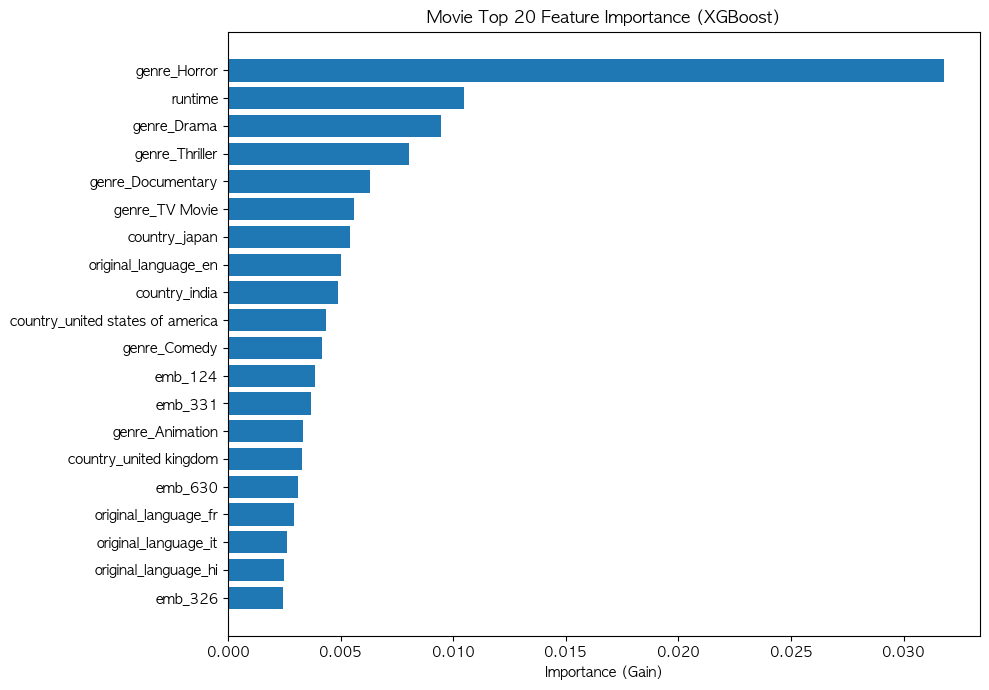

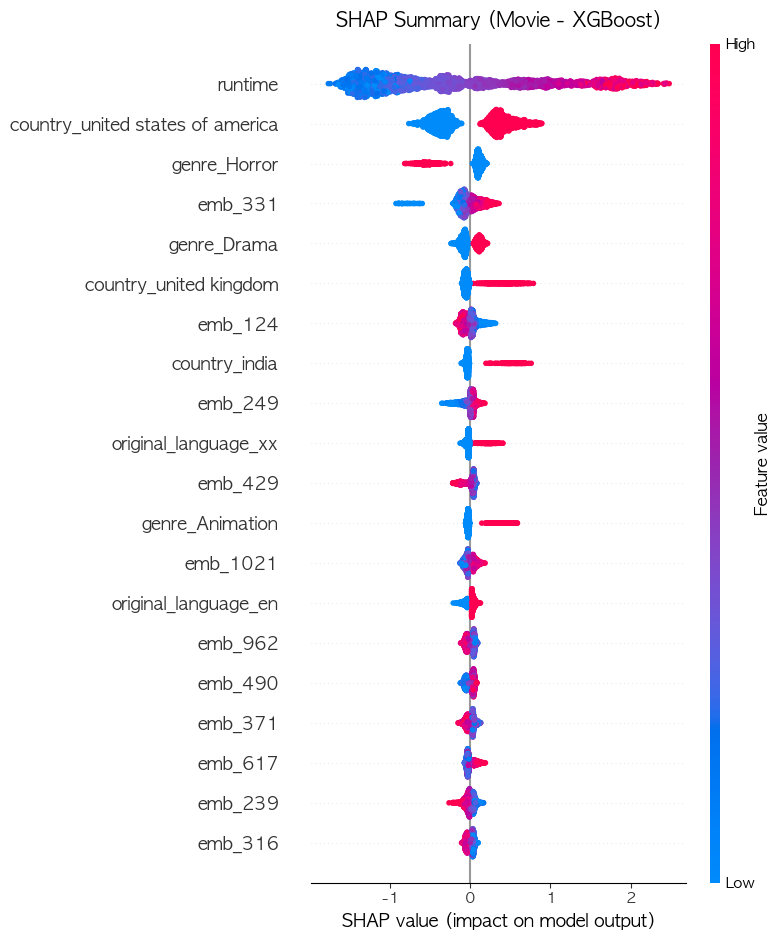

In [12]:
# ============================================================
# 영화 흥행 예측 모델 (XGBoost)
# ============================================================

print("="*60)
print("영화 흥행 예측 모델 XGBoost (상위20% vs 하위40%)")
print("="*60)

# 자동으로 클래스 가중치 계산
movie_sample_weights = compute_sample_weight(
    'balanced',
    y=movie_y_train
)

# ============================================================
# XGBoost 학습
# ============================================================
movie_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',        # 이진분류 + 로지스틱 손실함수 (확률 출력)
    n_estimators=5000,                  # 최대 트리 수 (early_stopping으로 자동 조정)
    learning_rate=0.03,                 # 학습률 (작을수록 정밀 학습)
    max_depth=6,                        # 트리 최대 깊이 (모델 복잡도 제어)
    subsample=0.85,                     # 데이터 샘플링 비율 (과적합 방지)
    colsample_bytree=0.85,              # 피처 샘플링 비율 (과적합 방지)
    reg_lambda=1.0,                     # L2 정규화 강도 (과적합 방지)
    random_state=RANDOM_STATE,          # 랜덤 시드 고정 (재현성 보장)
    n_jobs=-1,                          # 모든 CPU 코어 병렬 처리 (속도 최적화)
    eval_metric='auc',                  # 검증 지표 (Valid셋에서 AUC 계산)
    early_stopping_rounds=200           # Valid 성능 200회 악화시 학습 중단
)

movie_xgb_model.fit(
    movie_X_train, movie_y_train,
    eval_set=[(movie_X_valid, movie_y_valid)],
    sample_weight=movie_sample_weights,  # 개별 샘플 단위로 가중치 적용
    verbose=100
)

# ============================================================
# 평가
# ============================================================

# 검증 데이터에 대해 양성 클래스(레이블 1) 일 확률을 예측한 값. 이 확률을 그대로 써서 AUC를 계산
movie_xgb_pred_prob = movie_xgb_model.predict_proba(movie_X_valid)[:, 1]

# 예측 확률이 0.5 이상이면 1, 아니면 0으로 만들어서 최종 분류 결과(클래스 예측)를 만든 것 (이 이진 예측을 F1, Precision, Recall 계산에 사용)
movie_xgb_pred = (movie_xgb_pred_prob >= 0.5).astype(int)

print(f"\n[Movie XGBoost 성능]")
print(f"AUC: {roc_auc_score(movie_y_valid, movie_xgb_pred_prob):.4f}")
print(f"F1: {f1_score(movie_y_valid, movie_xgb_pred):.4f}")

# ============================================================
# XGBoost Threshold 실험 
# ============================================================
print("\n" + "="*60)
print("XGBoost Threshold 실험")
print("="*60)

movie_xgb_best_threshold = 0.5
movie_xgb_best_f1 = 0

for movie_xgb_threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    movie_xgb_pred = (movie_xgb_pred_prob >= movie_xgb_threshold).astype(int)
    
    movie_xgb_f1 = f1_score(movie_y_valid, movie_xgb_pred)
    movie_xgb_precision = precision_score(movie_y_valid, movie_xgb_pred)
    movie_xgb_recall = recall_score(movie_y_valid, movie_xgb_pred)
    
    print(f"\nThreshold: {movie_xgb_threshold}")
    print(f"  Precision: {movie_xgb_precision:.4f}")
    print(f"  Recall: {movie_xgb_recall:.4f}")
    print(f"  F1: {movie_xgb_f1:.4f}")
    
    # 클래스별 성능
    movie_xgb_cm = classification_report(movie_y_valid, movie_xgb_pred, output_dict=True, zero_division=0)
    print(f"  Recall (0): {movie_xgb_cm['0']['recall']:.4f}")
    print(f"  Recall (1): {movie_xgb_cm['1']['recall']:.4f}")
    
    if movie_xgb_f1 > movie_xgb_best_f1:
        movie_xgb_best_f1 = movie_xgb_f1
        movie_xgb_best_threshold = movie_xgb_threshold

print(f"\nMovie XGBoost 최적 Threshold: {movie_xgb_best_threshold} (F1: {movie_xgb_best_f1:.4f})")

# 최적 threshold로 최종 평가
movie_xgb_pred = (movie_xgb_pred_prob >= movie_xgb_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[Movie XGBoost 성능] (Threshold: {movie_xgb_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(movie_y_valid, movie_xgb_pred_prob):.4f}")
print(f"F1 Score: {f1_score(movie_y_valid, movie_xgb_pred):.4f}")
print(f"Precision: {precision_score(movie_y_valid, movie_xgb_pred):.4f}")
print(f"Recall: {recall_score(movie_y_valid, movie_xgb_pred):.4f}")
print("\n", classification_report(movie_y_valid, movie_xgb_pred))

# ============================================================
# Feature Importance
# ============================================================

# XGBoost가 계산한 각 피처의 gain 중요도 배열 (높을수록 모델 성능에 기여 ↑)
movie_xgb_imp = pd.DataFrame({
    'feature': movie_X_train.columns,
    'gain': movie_xgb_model.feature_importances_
}).sort_values('gain', ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(movie_xgb_imp.head(20)['feature'][::-1], movie_xgb_imp.head(20)['gain'][::-1])
plt.title('Movie Top 20 Feature Importance (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

# ============================================================
# SHAP : SHAP 해석기를 생성하고 검증 데이터에 대한 SHAP 값을 계산
# ============================================================

# XGBoost 모델에 대한 SHAP TreeExplainer 생성
movie_xgb_explainer = shap.TreeExplainer(movie_xgb_model)

# 검증 데이터에 대한 SHAP 중요도 값 계산
movie_xgb_shap_values = movie_xgb_explainer.shap_values(movie_X_valid)

# SHAP plot 생성 (show=False로 제목 추가 가능하게)
shap.summary_plot(
    movie_xgb_shap_values, 
    movie_X_valid, 
    max_display=20,
    show=False
)

# 제목 추가
plt.title("SHAP Summary (Movie - XGBoost)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

### 영화 흥행 예측 모델 (MLP)

영화 흥행 예측 모델 MLP (상위20% vs 하위40%)
Iteration 1, loss = 0.59478330
Validation score: 0.768185
Iteration 2, loss = 0.43797949
Validation score: 0.770584
Iteration 3, loss = 0.36131632
Validation score: 0.776179
Iteration 4, loss = 0.28948993
Validation score: 0.765787
Iteration 5, loss = 0.21912125
Validation score: 0.747402
Iteration 6, loss = 0.15713716
Validation score: 0.768185
Iteration 7, loss = 0.10884097
Validation score: 0.773781
Iteration 8, loss = 0.06680217
Validation score: 0.763389
Iteration 9, loss = 0.03604341
Validation score: 0.769784
Iteration 10, loss = 0.01977024
Validation score: 0.770584
Iteration 11, loss = 0.01104879
Validation score: 0.774580
Iteration 12, loss = 0.00641697
Validation score: 0.768985
Iteration 13, loss = 0.00436941
Validation score: 0.770584
Iteration 14, loss = 0.00338720
Validation score: 0.771383
Iteration 15, loss = 0.00280927
Validation score: 0.770584
Iteration 16, loss = 0.00241239
Validation score: 0.770584
Iteration 17, loss = 0.00214225


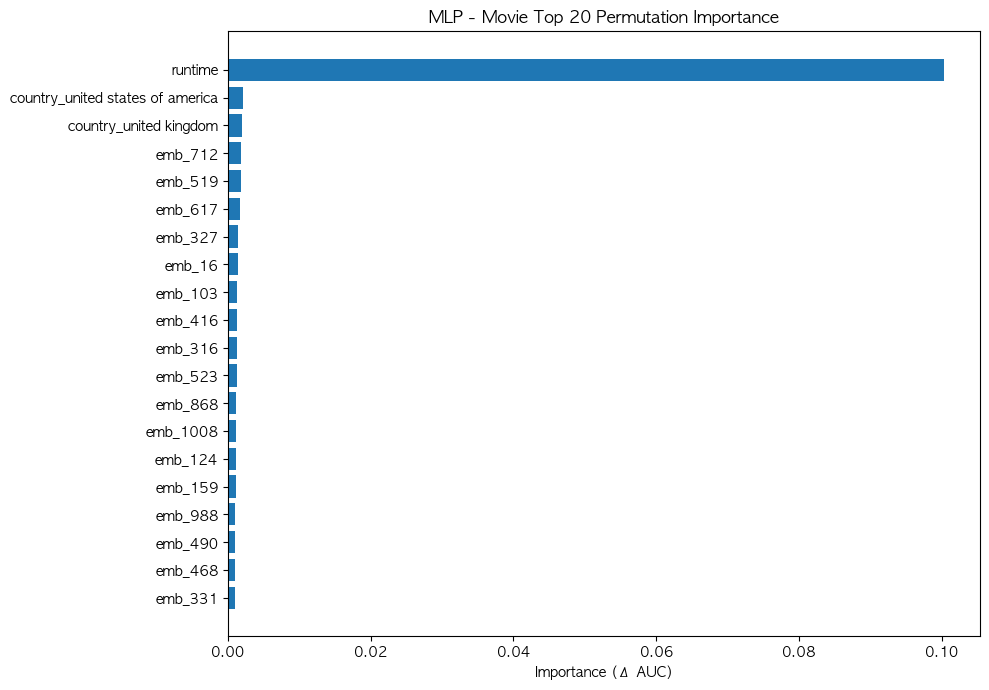


MLP - Movie Top 20 Permutation Importance:
                               feature  importance      group
0                              runtime    0.100356    runtime
41    country_united states of america    0.002172    country
40              country_united kingdom    0.001945    country
754                            emb_712    0.001854  embedding
561                            emb_519    0.001767  embedding
659                            emb_617    0.001699  embedding
369                            emb_327    0.001384  embedding
58                              emb_16    0.001346  embedding
145                            emb_103    0.001250  embedding
458                            emb_416    0.001238  embedding
358                            emb_316    0.001231  embedding
565                            emb_523    0.001208  embedding
910                            emb_868    0.001169  embedding
1050                          emb_1008    0.001157  embedding
166                       

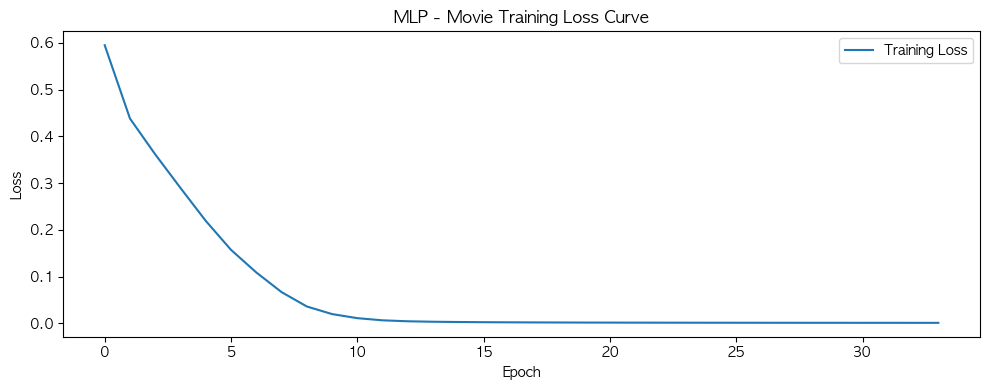

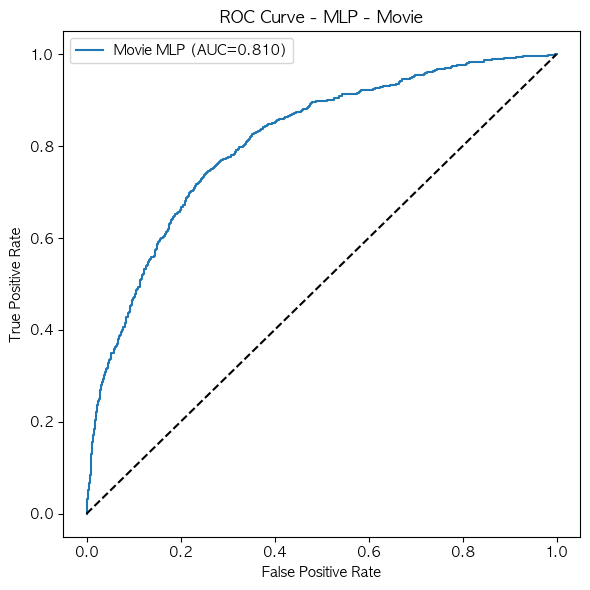

In [13]:
# ============================================================
# 영화 흥행 예측 모델 (MLP)
# ============================================================

print("="*60)
print("영화 흥행 예측 모델 MLP (상위20% vs 하위40%)")
print("="*60)

# ============================================================
# 선택적 스케일링
# ============================================================
# 연속형 컬럼만 스케일링: month_sin/cos, 임베딩 (원-핫 인코딩 변수, missing flags는 제외 (0/1 값 유지))
movie_continuous_cols = (
    ['month_sin', 'month_cos'] +
    [c for c in movie_X_train.columns if c.startswith('emb_')]
)

movie_scaler = StandardScaler()
movie_X_train_scaled = movie_X_train.copy()
movie_X_valid_scaled = movie_X_valid.copy()

movie_X_train_scaled[movie_continuous_cols] = movie_scaler.fit_transform(movie_X_train[movie_continuous_cols])
movie_X_valid_scaled[movie_continuous_cols] = movie_scaler.transform(movie_X_valid[movie_continuous_cols])

# ============================================================
# MLP 학습
# ============================================================
movie_mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128),          # 은닉층 구조 (중간 복잡도)
    activation='relu',                      # 활성화 함수: ReLU (비선형성 부여, 계산 빠름)
    solver='adam',                          # 최적화 알고리즘: Adam (적응적 학습률, 안정적 수렴)
    alpha=0.0005,                           # 중간 정규화
    learning_rate='adaptive',               # 학습률을 자동으로 조정
    learning_rate_init=0.0008,              # 초기 학습률 (작을수록 정밀 학습)
    max_iter=500,                           # 최대 학습 반복 횟수
    early_stopping=True,                    # 조기 종료 활성화 (과적합 방지)
    validation_fraction=0.1,                # 학습 데이터의 n%를 내부 검증용으로 분리
    n_iter_no_change=30,                    # 검증 성능 n회 안 좋아지면 조기 종료
    random_state=RANDOM_STATE,              # 랜덤 시드 고정 (재현성 보장)
    verbose=True                            # 학습 과정 상세 로그 출력
)

movie_mlp_model.fit(movie_X_train_scaled, movie_y_train)

# ============================================================
# 평가
# ============================================================
movie_mlp_pred_prob = movie_mlp_model.predict_proba(movie_X_valid_scaled)[:, 1]
movie_mlp_pred = (movie_mlp_pred_prob >= 0.5).astype(int)

print("\n" + "="*60)
print("\n[Movie MLP 성능]")
print("="*60)
print(f"AUC: {roc_auc_score(movie_y_valid, movie_mlp_pred_prob):.4f}")
print(f"F1 Score: {f1_score(movie_y_valid, movie_mlp_pred):.4f}")

# ============================================================
# MLP Threshold 실험 
# ============================================================

print("\n" + "="*60)
print("Movie MLP Threshold 실험")
print("="*60)

movie_mlp_best_threshold = 0.5
movie_mlp_best_f1 = 0

for movie_mlp_threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    tmp_movie_mlp_pred = (movie_mlp_pred_prob >= movie_mlp_threshold).astype(int)
    movie_mlp_f1 = f1_score(movie_y_valid, tmp_movie_mlp_pred)
    
    print(f"Threshold {movie_mlp_threshold:.1f} | F1: {movie_mlp_f1:.4f}")
    
    if movie_mlp_f1 > movie_mlp_best_f1:
        movie_mlp_best_f1 = movie_mlp_f1
        movie_mlp_best_threshold = movie_mlp_threshold

print(f"\nMLP 최적 Threshold: {movie_mlp_best_threshold} (F1={movie_mlp_best_f1:.4f})")

# 최적 threshold로 재예측
movie_mlp_pred = (movie_mlp_pred_prob >= movie_mlp_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[Movie MLP 성능] (Threshold: {movie_mlp_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(movie_y_valid, movie_mlp_pred_prob):.4f}")
print(f"F1 Score: {f1_score(movie_y_valid, movie_mlp_pred):.4f}")
print(f"Precision: {precision_score(movie_y_valid, movie_mlp_pred):.4f}")
print(f"Recall: {recall_score(movie_y_valid, movie_mlp_pred):.4f}")
print("\n", classification_report(movie_y_valid, movie_mlp_pred))

# ============================================================
# Permutation Importance
# ============================================================

movie_mlp_result = permutation_importance(
    movie_mlp_model,  # 학습된 모델 직접 사용
    movie_X_valid_scaled,   # 스케일된 데이터
    movie_y_valid,
    n_repeats=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="roc_auc"
)

movie_mlp_perm_imp = (
    pd.DataFrame({
        "feature": movie_X_valid.columns,
        "importance": movie_mlp_result.importances_mean
    })
    .sort_values("importance", ascending=False)
)

# ============================================================
# Feature Group 생성
# ============================================================
movie_mlp_perm_imp["group"] = np.where(
    movie_mlp_perm_imp["feature"].str.startswith("emb_"),
    "embedding",
    movie_mlp_perm_imp["feature"].str.split("_").str[0]
)

movie_mlp_group_imp = (
    movie_mlp_perm_imp.groupby("group")["importance"]
    .sum()
    .sort_values(ascending=False)
)

# ============================================================
# Top 20 그래프 출력
# ============================================================
plt.figure(figsize=(10, 7))
plt.barh(
    movie_mlp_perm_imp.head(20)["feature"][::-1],
    movie_mlp_perm_imp.head(20)["importance"][::-1]
)
plt.title("MLP - Movie Top 20 Permutation Importance")
plt.xlabel("Importance (Δ AUC)")
plt.tight_layout()
plt.show()

# ============================================================
# Top 20 텍스트 출력
# ============================================================
print("\nMLP - Movie Top 20 Permutation Importance:")
print(movie_mlp_perm_imp.head(20))

print("\n[Permutation Importance by Feature Group]")
print(movie_mlp_group_imp)

# ============================================================
# 학습 곡선
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(movie_mlp_model.loss_curve_, label="Training Loss")
plt.title("MLP - Movie Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# ROC Curve
# ============================================================
movie_mlp_fpr, movie_mlp_tpr, _ = roc_curve(movie_y_valid, movie_mlp_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(movie_mlp_fpr, movie_mlp_tpr, label=f"Movie MLP (AUC={roc_auc_score(movie_y_valid, movie_mlp_pred_prob):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP - Movie")
plt.legend()
plt.tight_layout()
plt.show()

### 영화 흥행 예측 앙상블 모델 (LightGBM + XGBoost + MLP)

영화 흥행 예측 - 앙상블 모델 (LightGBM + XGBoost + MLP)

[Ensemble (평균) - default threshold=0.5]
AUC: 0.8511
F1 Score: 0.6756
Precision: 0.6965
Recall: 0.6558

               precision    recall  f1-score   support

           0       0.83      0.86      0.84      2085
           1       0.70      0.66      0.68      1043

    accuracy                           0.79      3128
   macro avg       0.76      0.76      0.76      3128
weighted avg       0.79      0.79      0.79      3128


영화 앙상블 Threshold 실험
[BEST UPDATE] t=0.05 | F1=0.5547 | P=0.3870 | R=0.9789
[BEST UPDATE] t=0.06 | F1=0.5644 | P=0.3973 | R=0.9741
[BEST UPDATE] t=0.07 | F1=0.5754 | P=0.4095 | R=0.9674
[BEST UPDATE] t=0.08 | F1=0.5869 | P=0.4214 | R=0.9664
[BEST UPDATE] t=0.09 | F1=0.5955 | P=0.4315 | R=0.9607
[BEST UPDATE] t=0.10 | F1=0.6054 | P=0.4428 | R=0.9569
[BEST UPDATE] t=0.11 | F1=0.6147 | P=0.4537 | R=0.9530
[BEST UPDATE] t=0.12 | F1=0.6224 | P=0.4632 | R=0.9482
[BEST UPDATE] t=0.13 | F1=0.6305 | P=0.4725 | R=0.9473
[BEST U

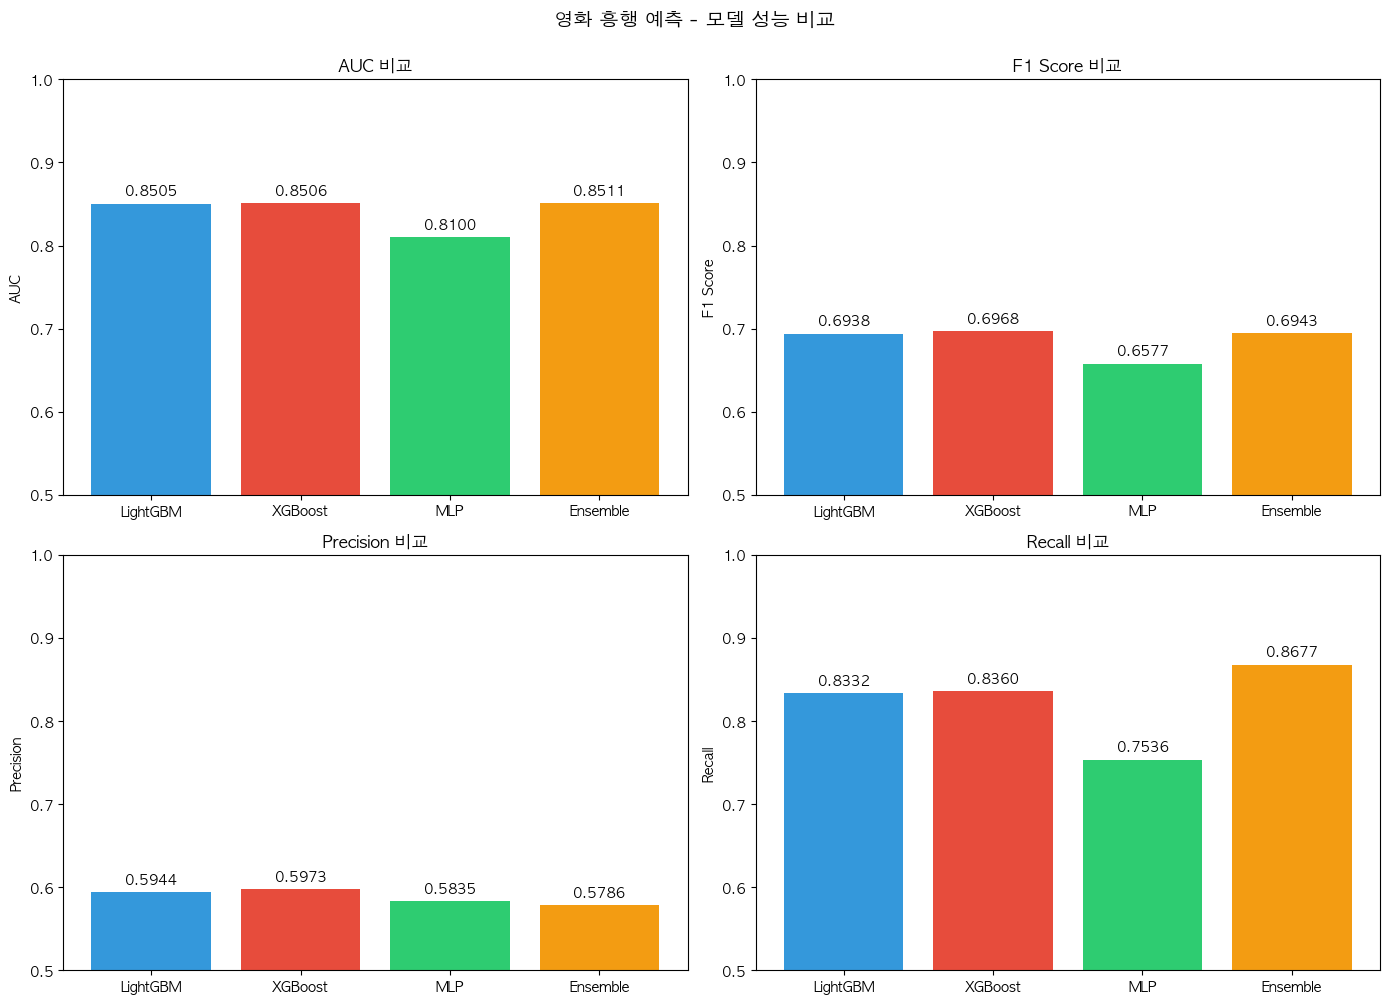

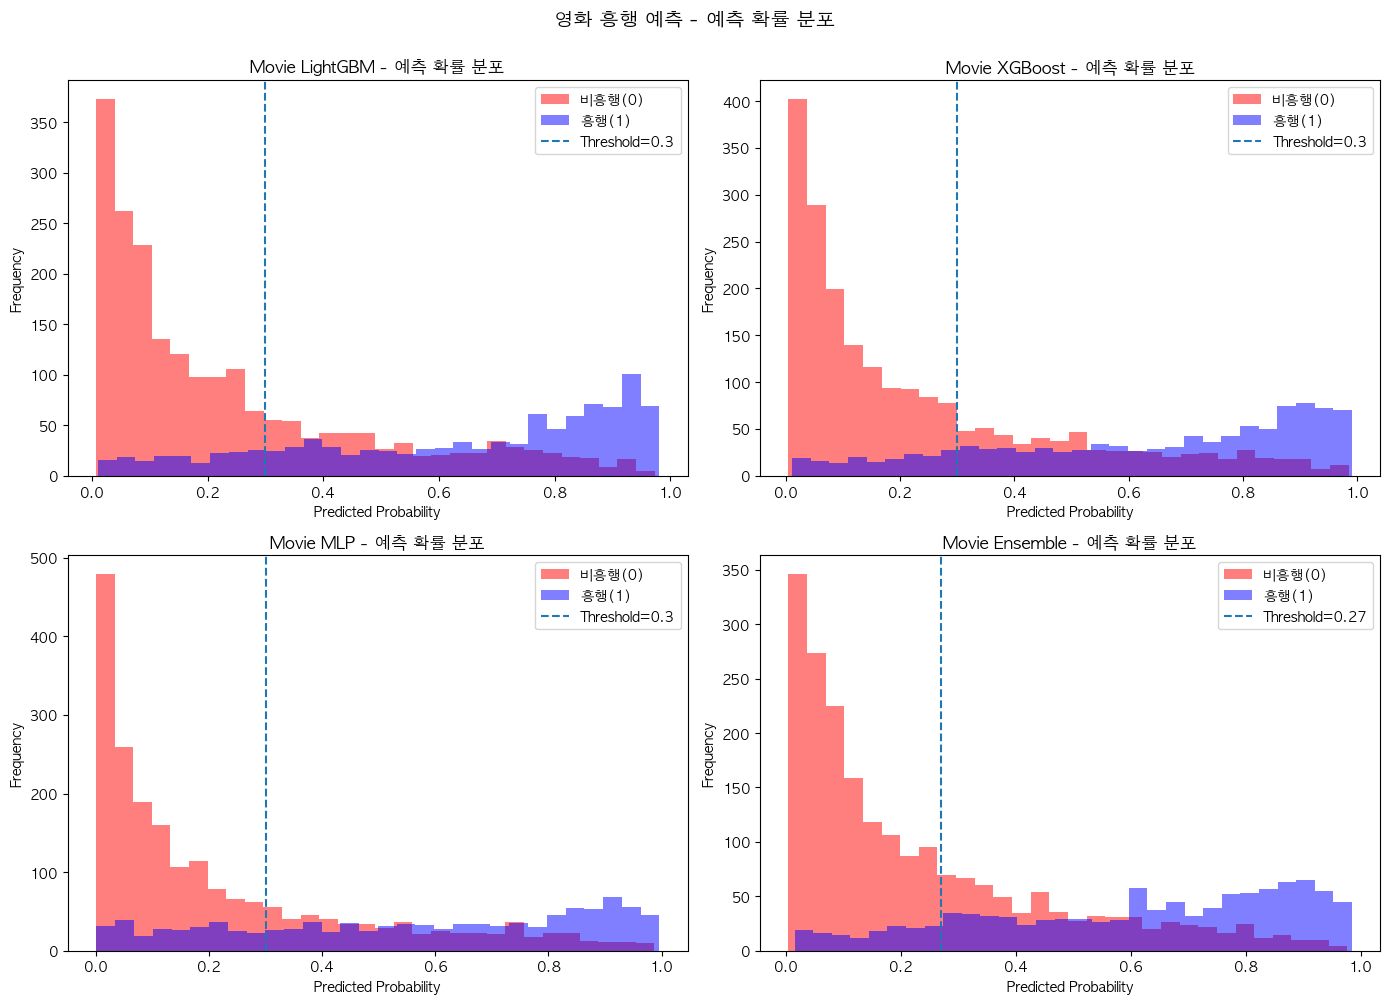

3개 모델 모두 동의(완전 일치): 79.4%
다수결 예측 정확도(majority vs True): 74.8%
앙상블 vs 다수결 일치율: 96.1%
Pairwise agreement - LGB/XGB: 93.6% | LGB/MLP: 82.6% | XGB/MLP: 82.7%


In [14]:
# ============================================================
# 영화 흥행 예측 앙상블 모델: 확률 평균 + Threshold 최적화
# - 3개 모델(LightGBM + XGBoost + MLP)의 예측을 앙상블하는 완성형 평가 코드
# ============================================================
print("="*60)
print("영화 흥행 예측 - 앙상블 모델 (LightGBM + XGBoost + MLP)")
print("="*60)

# ============================================================
# 1) 앙상블 확률: 3개 모델의 예측 확률을 단순 평균
# ============================================================
movie_ensemble_pred_prob = (movie_lgb_pred_prob + movie_xgb_pred_prob + movie_mlp_pred_prob) / 3

# ============================================================
# 2) 기본 Threshold(0.5)로 “참고용” 성능 출력
# - AUC는 threshold 없이 확률로 계산되므로 여기서 가장 의미 있음
# - Precision/Recall/F1은 threshold에 따라 크게 변하므로 아래에서 최적화
# ============================================================
default_thr = 0.5
movie_ensemble_pred_default = (movie_ensemble_pred_prob >= default_thr).astype(int)

print(f"\n[Ensemble (평균) - default threshold={default_thr}]")
print(f"AUC: {roc_auc_score(movie_y_valid, movie_ensemble_pred_prob):.4f}")  # 확률 기반 지표
print(f"F1 Score: {f1_score(movie_y_valid, movie_ensemble_pred_default):.4f}")
print(f"Precision: {precision_score(movie_y_valid, movie_ensemble_pred_default, zero_division=0):.4f}")
print(f"Recall: {recall_score(movie_y_valid, movie_ensemble_pred_default):.4f}")
print("\n", classification_report(movie_y_valid, movie_ensemble_pred_default, zero_division=0))

# ============================================================
# 3) Threshold 실험: F1 최대가 되는 threshold 찾기
# ============================================================
print("\n" + "="*60)
print("영화 앙상블 Threshold 실험")
print("="*60)

# best 값 초기화
movie_ensemble_best_threshold = None
movie_ensemble_best_f1 = -1.0
movie_ensemble_best_precision = None
movie_ensemble_best_recall = None

# threshold grid: 0.05 ~ 0.95까지 0.01 간격
thr_grid = np.round(np.arange(0.05, 0.96, 0.01), 2)

for movie_ensemble_t in thr_grid:
    # t 기준으로 이진 예측 생성
    tmp_movie_ensemble_pred = (movie_ensemble_pred_prob >= movie_ensemble_t).astype(int)
    
    # 양성 예측 0개면 precision 0/0 상황 발생 가능 → 스킵
    if tmp_movie_ensemble_pred.sum() == 0:
        continue
        
    # metric 계산
    tmp_movie_ensemble_f1 = f1_score(movie_y_valid, tmp_movie_ensemble_pred)
    tmp_movie_ensemble_precision = precision_score(movie_y_valid, tmp_movie_ensemble_pred, zero_division=0)
    tmp_movie_ensemble_recall = recall_score(movie_y_valid, tmp_movie_ensemble_pred)
    
    # best 갱신 로직이 없으면 best_threshold가 끝까지 None이 됨
    if tmp_movie_ensemble_f1 > movie_ensemble_best_f1:
        movie_ensemble_best_f1 = tmp_movie_ensemble_f1
        movie_ensemble_best_threshold = movie_ensemble_t
        movie_ensemble_best_precision = tmp_movie_ensemble_precision
        movie_ensemble_best_recall = tmp_movie_ensemble_recall
        
        # best가 바뀔 때만 로그 출력
        print(
            f"[BEST UPDATE] t={movie_ensemble_t:.2f} | F1={movie_ensemble_best_f1:.4f} | " 
            f"P={movie_ensemble_best_precision:.4f} | R={movie_ensemble_best_recall:.4f}"
        )

# best가 못 잡힌 경우 fallback
if movie_ensemble_best_threshold is None:
    movie_ensemble_best_threshold = default_thr
    movie_ensemble_best_f1 = f1_score(movie_y_valid, movie_ensemble_pred_default)
    movie_ensemble_best_precision = precision_score(movie_y_valid, movie_ensemble_pred_default, zero_division=0)
    movie_ensemble_best_recall = recall_score(movie_y_valid, movie_ensemble_pred_default)

print("\n" + "-" * 60)
print(f"최적 Threshold: {movie_ensemble_best_threshold} "
      f"(F1: {movie_ensemble_best_f1:.4f}, "
      f"P: {movie_ensemble_best_precision:.4f}, "
      f"R: {movie_ensemble_best_recall:.4f})")
print("-" * 60)

# ============================================================
# 4) 최적 threshold로 최종 앙상블 평가
# ============================================================
movie_ensemble_pred_final = (movie_ensemble_pred_prob >= movie_ensemble_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[영화 Ensemble 성능] (Threshold: {movie_ensemble_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(movie_y_valid, movie_ensemble_pred_prob):.4f}")
print(f"F1 Score: {f1_score(movie_y_valid, movie_ensemble_pred_final):.4f}")
print(f"Precision: {precision_score(movie_y_valid, movie_ensemble_pred_final, zero_division=0):.4f}")
print(f"Recall: {recall_score(movie_y_valid, movie_ensemble_pred_final):.4f}")
print("\n", classification_report(movie_y_valid, movie_ensemble_pred_final, zero_division=0))

# 모델별 "각자 best_threshold"로 고정 pred 만들어 비교 테이블에 넣기
movie_lgb_pred_final = (movie_lgb_pred_prob >= movie_lgb_best_threshold).astype(int)
movie_xgb_pred_final = (movie_xgb_pred_prob >= movie_xgb_best_threshold).astype(int)
movie_mlp_pred_final = (movie_mlp_pred_prob >= movie_mlp_best_threshold).astype(int)

# ============================================================
# 5) 성능 비교표
# ============================================================
movie_results = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'MLP', 'Ensemble'],
    'Threshold': [movie_lgb_best_threshold, movie_xgb_best_threshold, movie_mlp_best_threshold, movie_ensemble_best_threshold],
    'AUC': [
        roc_auc_score(movie_y_valid, movie_lgb_pred_prob),
        roc_auc_score(movie_y_valid, movie_xgb_pred_prob),
        roc_auc_score(movie_y_valid, movie_mlp_pred_prob),
        roc_auc_score(movie_y_valid, movie_ensemble_pred_prob)
    ],
    'F1': [
        f1_score(movie_y_valid, movie_lgb_pred_final),
        f1_score(movie_y_valid, movie_xgb_pred_final),
        f1_score(movie_y_valid, movie_mlp_pred_final),
        f1_score(movie_y_valid, movie_ensemble_pred_final)
    ],
    'Precision': [
        precision_score(movie_y_valid, movie_lgb_pred_final, zero_division=0),
        precision_score(movie_y_valid, movie_xgb_pred_final, zero_division=0),
        precision_score(movie_y_valid, movie_mlp_pred_final, zero_division=0),
        precision_score(movie_y_valid, movie_ensemble_pred_final, zero_division=0)
    ],
    'Recall': [
        recall_score(movie_y_valid, movie_lgb_pred_final),
        recall_score(movie_y_valid, movie_xgb_pred_final),
        recall_score(movie_y_valid, movie_mlp_pred_final),
        recall_score(movie_y_valid, movie_ensemble_pred_final)
    ]
})

print("\n" + "="*60)
print("모델 성능 비교")
print("="*60)
print(movie_results.to_string(index=False))

# ============================================================
# 6) 시각화: 모델 성능 비교
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# AUC
axes[0, 0].bar(movie_results['Model'], movie_results['AUC'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[0, 0].set_title('AUC 비교', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_ylim([0.5, 1.0])
for i, v in enumerate(movie_results['AUC']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# F1 Score
axes[0, 1].bar(movie_results['Model'], movie_results['F1'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[0, 1].set_title('F1 Score 비교', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_ylim([0.5, 1.0])
for i, v in enumerate(movie_results['F1']):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# Precision
axes[1, 0].bar(movie_results['Model'], movie_results['Precision'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[1, 0].set_title('Precision 비교', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_ylim([0.5, 1.0])
for i, v in enumerate(movie_results['Precision']):
    axes[1, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# Recall
axes[1, 1].bar(movie_results['Model'], movie_results['Recall'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[1, 1].set_title('Recall 비교', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_ylim([0.5, 1.0])
for i, v in enumerate(movie_results['Recall']):
    axes[1, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.suptitle('영화 흥행 예측 - 모델 성능 비교', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============================================================
# 예측 확률 분포
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

movie_plot_items = [
    ("Movie LightGBM", movie_lgb_pred_prob, movie_lgb_best_threshold),
    ("Movie XGBoost",  movie_xgb_pred_prob, movie_xgb_best_threshold),
    ("Movie MLP",      movie_mlp_pred_prob, movie_mlp_best_threshold),
    ("Movie Ensemble", movie_ensemble_pred_prob, movie_ensemble_best_threshold),
]

for idx, (name, probs, thr) in enumerate(movie_plot_items):
    ax = axes[idx // 2, idx % 2]
    ax.hist(probs[movie_y_valid == 0], bins=30, alpha=0.5, label="비흥행(0)", color="red")
    ax.hist(probs[movie_y_valid == 1], bins=30, alpha=0.5, label="흥행(1)", color="blue")
    ax.axvline(thr, linestyle="--", label=f"Threshold={thr}")
    ax.set_title(f"{name} - 예측 확률 분포", fontweight="bold")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.suptitle("영화 흥행 예측 - 예측 확률 분포", fontsize=14, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

# ============================================================
# 7) 모델 간 예측 일치도 (agreement)
#    - agreement는 같은 threshold 기준에서 비교해야 의미가 있으므로
#      앙상블 최적 threshold를 공통 기준으로 사용
# ============================================================

movie_common_thr = movie_ensemble_best_threshold

# 3개 베이스 모델의 이진 예측 (공통 threshold로 통일)
movie_base_pred_df = pd.DataFrame({
    "LightGBM": (movie_lgb_pred_prob >= movie_common_thr).astype(int),
    "XGBoost":  (movie_xgb_pred_prob >= movie_common_thr).astype(int),
    "MLP":      (movie_mlp_pred_prob >= movie_common_thr).astype(int),
})

# 1) 3개 모델 '완전 일치' 비율 (의견이 전부 같음)
movie_all_agree = (movie_base_pred_df.nunique(axis=1) == 1)   # 각 행에서 유니크 값 개수가 1이면 3개가 동일
print(f"3개 모델 모두 동의(완전 일치): {movie_all_agree.mean() * 100:.1f}%")

# 2) 다수결(majority vote) 예측 + 다수결 정확도(=정답과 일치한 비율)
movie_majority_pred = (movie_base_pred_df.sum(axis=1) >= 2).astype(int)  # 1이 2개 이상이면 1
movie_majority_acc = (movie_majority_pred.values == np.asarray(movie_y_valid)).mean()
print(f"다수결 예측 정확도(majority vs True): {movie_majority_acc * 100:.1f}%")

# 3) 앙상블(확률 평균) 이진 예측이 다수결과 얼마나 같은지
movie_ensemble_pred_common = (movie_ensemble_pred_prob >= movie_common_thr).astype(int)
movie_ensemble_vs_majority = (movie_ensemble_pred_common == movie_majority_pred.values).mean()
print(f"앙상블 vs 다수결 일치율: {movie_ensemble_vs_majority * 100:.1f}%")

# 4) 참고: 쌍별(pairwise) 일치율
movie_pair_lgb_xgb = (movie_base_pred_df["LightGBM"] == movie_base_pred_df["XGBoost"]).mean()
movie_pair_lgb_mlp = (movie_base_pred_df["LightGBM"] == movie_base_pred_df["MLP"]).mean()
movie_pair_xgb_mlp = (movie_base_pred_df["XGBoost"] == movie_base_pred_df["MLP"]).mean()
print(f"Pairwise agreement - LGB/XGB: {movie_pair_lgb_xgb * 100:.1f}% | "
      f"LGB/MLP: {movie_pair_lgb_mlp * 100:.1f}% | XGB/MLP: {movie_pair_xgb_mlp * 100:.1f}%")

### 영화 앙상블 결과 해석


## 예측 모델링 (드라마)

### 드라마 데이터 전처리 및 피처 엔지니어링

#### (1) 데이터 로드+ 통합 중복 제거

In [15]:
# 드라마 데이터 로드+ 통합 중복 제거
drama_main = pd.read_parquet('files/drama/00_drama_main.parquet').drop_duplicates("imdb_id")
drama_genre = pd.read_parquet('files/drama/01_drama_genre.parquet')  # groupby로 중복 처리
drama_country = pd.read_parquet('files/drama/02_drama_country.parquet')  # groupby로 중복 처리
drama_emb = pd.read_parquet('files/drama/08_drama_text_embedding.parquet').drop_duplicates("imdb_id")
hit_score = pd.read_parquet('files/00_hit_score.parquet').drop_duplicates("imdb_id", keep='last')

#### (2) drama_main: 방영 월 순환 인코딩 + 언어 원핫


In [16]:
# drama_main: 방영 월 순환 인코딩 + 언어 원핫
drama_main_cleaned = drama_main[["imdb_id", "original_language", "first_air_date"]].copy()

# first_air_date → month → 순환 인코딩
drama_main_cleaned["first_air_date"] = pd.to_datetime(drama_main_cleaned["first_air_date"], errors="coerce")
drama_main_cleaned["first_air_month"] = drama_main_cleaned["first_air_date"].dt.month

drama_m = drama_main_cleaned["first_air_month"].fillna(0)
drama_main_cleaned["month_sin"] = np.where(drama_m > 0, np.sin(2*np.pi*drama_m/12), 0.0)
drama_main_cleaned["month_cos"] = np.where(drama_m > 0, np.cos(2*np.pi*drama_m/12), 0.0)

drama_main_cleaned = drama_main_cleaned.drop(columns=["first_air_date", "first_air_month"])

# original_language 원핫 인코딩
drama_main_cleaned["original_language"] = (
    drama_main_cleaned["original_language"]
    .astype("string")
    .fillna("unk")
)
drama_main_cleaned = pd.get_dummies(drama_main_cleaned, columns=["original_language"], drop_first=True)
drama_main_cleaned

,imdb_id,month_sin,month_cos,original_language_bg,original_language_ca,original_language_cs,original_language_cy,original_language_da,original_language_de,original_language_el,...,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_th,original_language_tl,original_language_tr,original_language_zh
0,tt0412175,5.000000e-01,8.660254e-01,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,tt0439100,-8.660254e-01,-5.000000e-01,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,tt0772137,-8.660254e-01,5.000000e-01,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tt0756509,1.224647e-16,-1.000000e+00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,tt0496275,5.000000e-01,8.660254e-01,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,tt37504309,-5.000000e-01,-8.660254e-01,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3313,tt28243363,1.224647e-16,-1.000000e+00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3314,tt37370861,1.224647e-16,-1.000000e+00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3315,tt37065878,-1.000000e+00,-1.836970e-16,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### (3) drama_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)

In [17]:
# drama_genre: 멀티라벨 인코딩 (MultiLabelBinarizer)
drama_genre_list = drama_genre.groupby("imdb_id")["genre"].apply(list).reset_index()

drama_mlb = MultiLabelBinarizer()
drama_genre_ohe = drama_mlb.fit_transform(drama_genre_list["genre"])

drama_genre_ohe = pd.DataFrame(drama_genre_ohe, columns=[f"genre_{g}" for g in drama_mlb.classes_])
drama_genre_ohe["imdb_id"] = drama_genre_list["imdb_id"].values
drama_genre_ohe

,genre_Action & Adventure,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Mystery,genre_Sci-Fi & Fantasy,genre_Soap,genre_War & Politics,genre_Western,imdb_id
0,0,0,1,1,0,0,0,0,0,0,tt0320882
1,1,0,0,1,0,0,0,0,1,0,tt0374463
2,0,0,0,1,0,0,0,0,0,0,tt0376591
3,0,0,0,1,0,0,0,0,0,0,tt0384013
4,1,0,0,1,0,0,0,0,0,0,tt0384766
...,...,...,...,...,...,...,...,...,...,...,...
3344,0,0,0,1,0,0,1,0,0,0,tt9892936
3345,0,1,0,1,0,0,0,0,0,0,tt9894488
3346,0,0,1,1,0,1,0,0,0,0,tt9899068
3347,0,1,0,1,0,0,0,0,0,0,tt9899340


#### (4) drama_country: 원핫 인코딩

In [18]:
# drama_country: 원핫 인코딩
drama_country_ohe = pd.get_dummies(
    drama_country,
    columns=["origin_country"],
    prefix="country",
    drop_first=True
)

drama_country_ohe = drama_country_ohe.groupby("imdb_id", as_index=False).sum()
drama_country_ohe

,imdb_id,country_cn,country_co,country_es,country_fr,country_gb,country_kr,country_mx,country_other,country_tr,country_us
0,tt0320882,0,0,0,0,0,0,0,1,0,0
1,tt0374463,0,0,0,0,0,0,0,0,0,1
2,tt0376591,0,0,0,0,0,0,0,0,0,1
3,tt0384013,0,0,0,0,1,0,0,0,0,0
4,tt0384766,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3344,tt9892936,0,1,0,0,0,0,0,0,0,0
3345,tt9894488,0,0,1,0,0,0,0,0,0,0
3346,tt9899068,0,0,0,0,0,0,0,1,0,0
3347,tt9899340,0,0,0,0,0,1,0,0,0,0


#### (5) overview + genre 텍스트 임베딩 전처리

In [19]:
# 드라마 줄거리 + 장르 텍스트 임베딩 전처리 (1024차원)
drama_emb = drama_emb[['imdb_id', 'embedding']].copy()

# 문자열인 경우 리스트로 변환
def to_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

drama_emb["embedding"] = drama_emb["embedding"].apply(to_list)

# 1024개 컬럼으로 펼치기
drama_emb_df = pd.DataFrame(
    drama_emb['embedding'].tolist(),
    columns=[f'emb_{i}' for i in range(1024)]
)

drama_emb_final = pd.concat([
    drama_emb[['imdb_id']].reset_index(drop=True),
    drama_emb_df
], axis=1)

print(f"Drama 임베딩 컬럼: {drama_emb_final.shape[1] - 1}개") # imdb_id 제외한 개수
drama_emb_final

Drama 임베딩 컬럼: 1024개


,imdb_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_1014,emb_1015,emb_1016,emb_1017,emb_1018,emb_1019,emb_1020,emb_1021,emb_1022,emb_1023
0,tt0412175,0.062165,-0.047462,-0.011275,0.000071,0.031128,-0.015776,-0.020381,0.011014,0.011808,...,-0.074372,0.055118,-0.031068,-0.054953,-0.025432,0.038945,0.020895,-0.010732,0.008948,0.007460
1,tt0439100,0.011015,-0.015213,-0.005985,0.039621,0.064544,-0.047428,-0.023120,-0.017955,-0.016193,...,-0.032828,0.002050,-0.004482,-0.001507,-0.053625,0.001865,0.007361,-0.025910,-0.026196,-0.003117
2,tt0772137,-0.003276,-0.068187,-0.014158,0.064806,0.063349,-0.047482,-0.043726,-0.063236,-0.009833,...,-0.000058,-0.003730,-0.007398,-0.018294,-0.023534,0.025979,-0.003356,-0.025348,-0.026999,-0.020195
3,tt0756509,0.061557,-0.038613,-0.009120,0.018144,0.079962,-0.005202,-0.005052,0.003935,-0.019911,...,-0.001773,-0.011519,-0.014517,-0.020102,0.009772,-0.008870,0.018118,-0.008200,0.017012,0.002055
4,tt0496275,0.106894,-0.010332,-0.004868,0.057457,0.041786,-0.020933,-0.021326,-0.065778,-0.005257,...,-0.017054,-0.000050,-0.000923,0.060119,-0.002461,0.004959,0.033447,0.015384,0.035809,-0.041201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,tt37504309,0.032956,-0.072119,-0.009310,0.036759,0.083490,-0.077133,-0.040381,0.018082,0.054821,...,-0.032801,0.007150,-0.041543,-0.021615,-0.009464,0.015099,0.002094,0.002166,-0.008970,0.009528
3313,tt28243363,0.042599,-0.048198,-0.004771,0.032712,0.035744,-0.028012,-0.040246,-0.028243,0.001827,...,-0.031915,0.014502,-0.059681,-0.009028,-0.040542,-0.002591,0.000572,0.001118,0.019660,0.022265
3314,tt37370861,0.058356,-0.089854,-0.009839,-0.007464,0.079359,-0.046225,-0.014303,-0.001967,0.002485,...,-0.023240,-0.014225,0.022824,0.000964,-0.059413,-0.005977,0.017259,-0.022324,0.012013,-0.007210
3315,tt37065878,0.023379,-0.093595,-0.007426,-0.004823,0.069042,-0.033881,-0.046562,-0.025151,-0.017759,...,-0.038226,-0.004025,-0.049757,0.024534,-0.021420,0.002698,0.008980,-0.029322,0.027794,-0.007484


#### (6) Feature Table 병합

In [20]:
# 드라마 Feature Table 병합
print(f"Drama Feature Table 병합 전: {drama_main_cleaned.shape}")

# 전처리한 피처 병합
drama_merged = (
    drama_main_cleaned.copy()
    .merge(drama_genre_ohe, on="imdb_id", how="left")
    .merge(drama_country_ohe, on="imdb_id", how="left")
    .merge(drama_emb_final, on="imdb_id", how="left")
    .merge(hit_score[["imdb_id", "hit_score"]], on="imdb_id", how="inner")
)

print(f"Drama Feature Table 병합 후: {drama_merged.shape}")

Drama Feature Table 병합 전: (3317, 36)
Drama Feature Table 병합 후: (3210, 1081)


#### (7) 타겟(y) 생성: 흥행 라벨링 (상위20% = 1, 하위40% = 0, 중간40% 제거)

In [21]:
# 타겟(y) 생성: 상위20% = 1, 하위40% = 0, 중간40% 제거
q80 = drama_merged["hit_score"].quantile(0.8)  # 상위 20% 기준
q40 = drama_merged["hit_score"].quantile(0.4)  # 하위 40% 기준

drama_merged["y"] = np.where(
    drama_merged["hit_score"] >= q80, 1,           # 상위 20%
    np.where(drama_merged["hit_score"] <= q40, 0,  # 하위 40%
             np.nan)                               # 중간 40% (제거)
)

drama_merged = drama_merged.dropna(subset=["y"])
drama_merged["y"] = drama_merged["y"].astype(int)
drama_merged = drama_merged.drop(columns=["hit_score"]) # hit_score 제거 (데이터 누수 방지)

print(f"라벨링 후 (상위20%=1, 하위40%=0, 중간 40%=제거): {drama_merged.shape}")
print(f"Drama Label 분포:")
print(drama_merged["y"].value_counts(normalize=True))

라벨링 후 (상위20%=1, 하위40%=0, 중간 40%=제거): (1926, 1081)
Drama Label 분포:
y
0    0.666667
1    0.333333
Name: proportion, dtype: float64


#### (8) 드라마 병합 테이블 결측치 처리

In [22]:
# 결측치 처리 (변수 타입별로 다르게)

# 1) 원-핫 인코딩 변수: NaN → 0으로 채우기
drama_dummy_prefixes = ('genre_', 'country_', 'original_language_')
drama_dummy_cols = [c for c in drama_merged.columns if c.startswith(drama_dummy_prefixes)]
drama_merged[drama_dummy_cols] = drama_merged[drama_dummy_cols].fillna(0)

# 2) 임베딩: all-null → 0 + missing flag
drama_emb_cols = [c for c in drama_merged.columns if c.startswith("emb_")]
drama_merged["embedding_missing"] = drama_merged[drama_emb_cols].isnull().all(axis=1).astype(int)
drama_merged[drama_emb_cols] = drama_merged[drama_emb_cols].fillna(0)

# 마지막 남은 결측치 안전하게 처리
drama_remaining_nulls = drama_merged.isnull().sum()
if drama_remaining_nulls.sum() > 0:
    print(f"\n⚠️ 남은 결측치:\n{drama_remaining_nulls[drama_remaining_nulls > 0]}")
    drama_merged = drama_merged.fillna(0)

print("결측치 처리 완료")
print(f"Drama Final Feature Table Shape: {drama_merged.shape}")
print(f"Drama Label balance: {drama_merged['y'].value_counts(normalize=True).to_dict()}")

결측치 처리 완료
Drama Final Feature Table Shape: (1926, 1082)
Drama Label balance: {0: 0.6666666666666666, 1: 0.3333333333333333}


#### (9) 드라마 Train/Valid Split

In [23]:
# 드라마 Train/Valid Split
drama_X = drama_merged.drop(columns=["imdb_id", "y"])
drama_y = drama_merged["y"].values

drama_X_train, drama_X_valid, drama_y_train, drama_y_valid = train_test_split(
    drama_X, drama_y, test_size=0.2, stratify=drama_y, random_state=RANDOM_STATE
)

print(f"Drama Train: {drama_X_train.shape}, Drama Valid: {drama_X_valid.shape}") # 학습/검증 데이터 크기
print(f"Drama Train label 분포: {np.bincount(drama_y_train)}") # bincount: 학습 레이블의 클래스별 개수
print(f"Drama Valid label 분포: {np.bincount(drama_y_valid)}") # bincount: 검증 레이블의 클래스별 개수

Drama Train: (1540, 1080), Drama Valid: (386, 1080)
Drama Train label 분포: [1027  513]
Drama Valid label 분포: [257 129]


### 드라마 흥행 예측 모델 (LightGBM)

드라마 흥행 예측 모델 LightGBM (상위20% vs 하위40%)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 513, number of negative: 1027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261180
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 1045
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

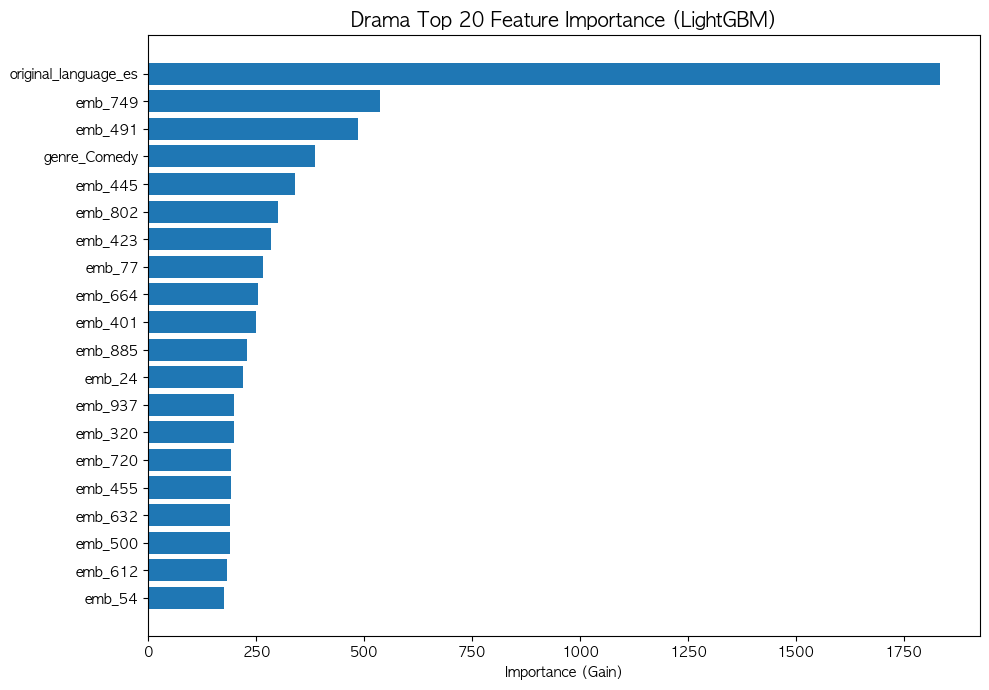

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


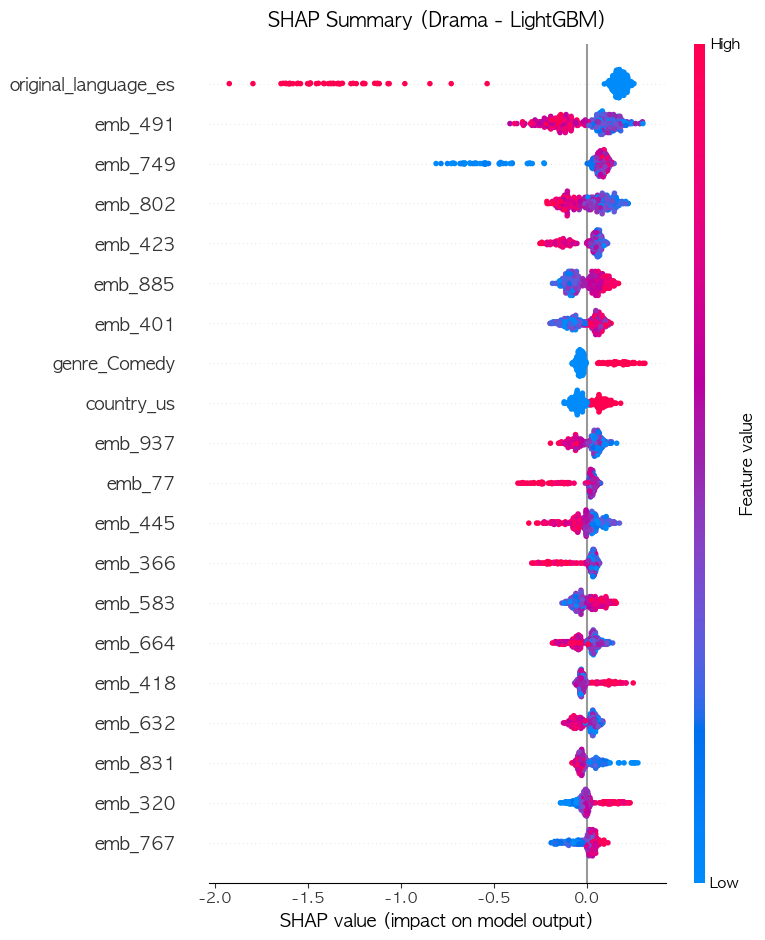

In [24]:
# ============================================================
# 드라마 흥행 예측 모델 (LightGBM)
# ============================================================

print("="*60)
print("드라마 흥행 예측 모델 LightGBM (상위20% vs 하위40%)")
print("="*60)

# ============================================================
# LightGBM 학습
# ============================================================
drama_lgb_model = lgb.LGBMClassifier(
    objective="binary",                 # 이진분류 문제 (흥행1/비흥행0)
    n_estimators=5000,                  # 최대 트리 수 (early_stopping으로 자동 조정)
    learning_rate=0.025,                 # 학습 속도 (작을수록 천천히 정확히 학습)
    num_leaves=63,                      # 한 트리당 최대 리프 수 (복잡도 제어)
    min_child_samples=35,               # 리프 최소 샘플 수 (과적합 방지)
    subsample=0.85,                      # 데이터 무작위 사용 비율 (샘플링)
    colsample_bytree=0.85,               # 피처 무작위 사용 비율 (피처 샘플링)
    reg_lambda=1.2,                     # L2 정규화 (과적합 방지)
    reg_alpha=0.2,                      # 약한 L1 추가
    max_depth=8,                        # 깊이 제한
    class_weight='balanced',            # 클래스 비율에 따라 자동 클래스 가중치 적용 (소수 클래스(흥행) 학습 비중 강화)
    random_state=RANDOM_STATE,          # 랜덤 시드 고정 (매 실행마다 똑같은 결과 보장)
    n_jobs=-1,                          # 모든 CPU 코어 병렬 사용 (트리 학습 시 최대 속도)
)

drama_lgb_model.fit(
    drama_X_train, drama_y_train,                   # 학습 데이터
    eval_set=[(drama_X_valid, drama_y_valid)],      # 검증 데이터 (학습 중 성능 체크용)
    eval_metric="auc",                  # 평가 지표 (Valid에서 AUC 계산)
    callbacks=[lgb.early_stopping(200), # 과적합 방지 (Valid 성능 200회 안 좋아지면 자동 멈춤) 
               lgb.log_evaluation(100)] # 로그 출력 (100회마다 학습 상태 출력)
)

# ============================================================
# 평가 + Threshold 실험
# ============================================================
drama_lgb_pred_prob = drama_lgb_model.predict_proba(drama_X_valid)[:, 1]
drama_lgb_pred = (drama_lgb_pred_prob >= 0.5).astype(int)

# ============================================================
# LightGBM Threshold 실험
# ============================================================
print("\n" + "="*60)
print("Threshold 실험")
print("="*60)

drama_lgb_best_threshold = 0.5
drama_lgb_best_f1 = 0

for drama_lgb_threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    tmp_lgb_pred = (drama_lgb_pred_prob >= drama_lgb_threshold).astype(int)
    
    drama_lgb_f1 = f1_score(drama_y_valid, tmp_lgb_pred)
    drama_lgb_precision = precision_score(drama_y_valid, tmp_lgb_pred)
    drama_lgb_recall = recall_score(drama_y_valid, tmp_lgb_pred)
    
    print(f"\nThreshold: {drama_lgb_threshold}")
    print(f"  Precision: {drama_lgb_precision:.4f}")
    print(f"  Recall: {drama_lgb_recall:.4f}")
    print(f"  F1: {drama_lgb_f1:.4f}")
    
    drama_lgb_cm = classification_report(drama_y_valid, tmp_lgb_pred, output_dict=True, zero_division=0)
    print(f"  Recall (0): {drama_lgb_cm['0']['recall']:.4f}")
    print(f"  Recall (1): {drama_lgb_cm['1']['recall']:.4f}")
    
    if drama_lgb_f1 > drama_lgb_best_f1:
        drama_lgb_best_f1 = drama_lgb_f1
        drama_lgb_best_threshold = drama_lgb_threshold

print(f"\n최적 Threshold: {drama_lgb_best_threshold} (F1: {drama_lgb_best_f1:.4f})")

# 최적 threshold로 재예측
drama_lgb_pred = (drama_lgb_pred_prob >= drama_lgb_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[Drama LightGBM 성능] (Threshold: {drama_lgb_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(drama_y_valid, drama_lgb_pred_prob):.4f}")    # AUC: 모델이 흥행/비흥행을 얼마나 잘 구분하는지 (0~1, 0.5=랜덤, 1=완벽)
print(f"F1 Score: {f1_score(drama_y_valid, drama_lgb_pred):.4f}")         # F1: Precision과 Recall의 조화평균 (0~1, 특정 threshold=0.5 기준)
print(f"Precision: {precision_score(drama_y_valid, drama_lgb_pred):.4f}") # Precision (정밀도): 흥행이라고 예측한 것 중 실제 흥행인 비율
print(f"Recall: {recall_score(drama_y_valid, drama_lgb_pred):.4f}")       # Recall (재현율): 실제 흥행인 것 중 흥행이라고 예측한 비율
print("\n", classification_report(drama_y_valid, drama_lgb_pred))

# ============================================================
# Feature Importance
# ============================================================
drama_lgb_imp = pd.DataFrame({
    "feature": drama_X_train.columns,
    "gain": drama_lgb_model.booster_.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(drama_lgb_imp.head(20)["feature"][::-1], drama_lgb_imp.head(20)["gain"][::-1])
plt.title("Drama Top 20 Feature Importance (LightGBM)", fontsize=14, fontweight='bold')
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

# ============================================================
# SHAP
# ============================================================
drama_lgb_explainer = shap.TreeExplainer(drama_lgb_model.booster_)
drama_lgb_shap_values = drama_lgb_explainer.shap_values(drama_X_valid)

# shap_values가 list로 나오면 (클래스별) 1번 클래스(흥행=1)를 사용
if isinstance(drama_lgb_shap_values, list):
    drama_lgb_shap_values_plot = drama_lgb_shap_values[1]
else:
    drama_lgb_shap_values_plot = drama_lgb_shap_values

shap.summary_plot(
    drama_lgb_shap_values_plot,
    drama_X_valid,
    max_display=20,
    show=False
)

plt.title("SHAP Summary (Drama - LightGBM)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

### 드라마 흥행 예측 모델 (XGBoost)

드라마 흥행 예측 모델 XGBoost (상위20% vs 하위40%)
[0]	validation_0-auc:0.64940
[100]	validation_0-auc:0.73722
[200]	validation_0-auc:0.73933
[300]	validation_0-auc:0.74476
[400]	validation_0-auc:0.75230
[500]	validation_0-auc:0.75342
[600]	validation_0-auc:0.75492
[700]	validation_0-auc:0.75812
[800]	validation_0-auc:0.76108
[900]	validation_0-auc:0.75803
[1000]	validation_0-auc:0.75803

[Drama XGBoost 성능]
AUC: 0.7611
F1: 0.5025

XGBoost Threshold 실험

Threshold: 0.3
  Precision: 0.5625
  Recall: 0.6279
  F1: 0.5934
  Recall (0): 0.7549
  Recall (1): 0.6279

Threshold: 0.4
  Precision: 0.5922
  Recall: 0.4729
  F1: 0.5259
  Recall (0): 0.8366
  Recall (1): 0.4729

Threshold: 0.5
  Precision: 0.7143
  Recall: 0.3876
  F1: 0.5025
  Recall (0): 0.9222
  Recall (1): 0.3876

Threshold: 0.6
  Precision: 0.7660
  Recall: 0.2791
  F1: 0.4091
  Recall (0): 0.9572
  Recall (1): 0.2791

Threshold: 0.7
  Precision: 0.8667
  Recall: 0.2016
  F1: 0.3270
  Recall (0): 0.9844
  Recall (1): 0.2016

최적 Threshold: 0.

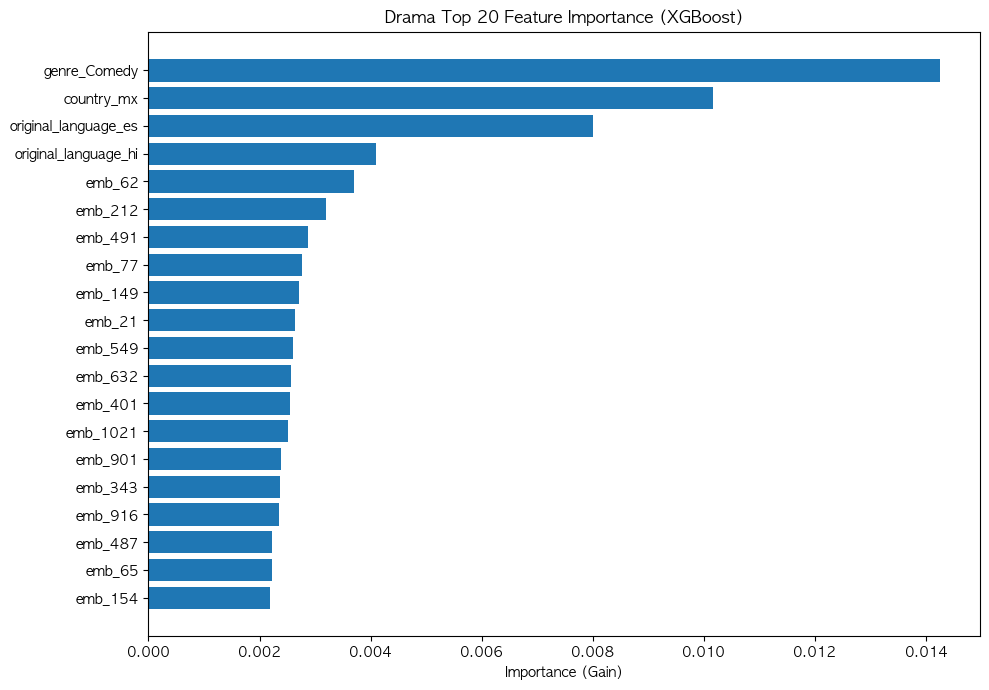

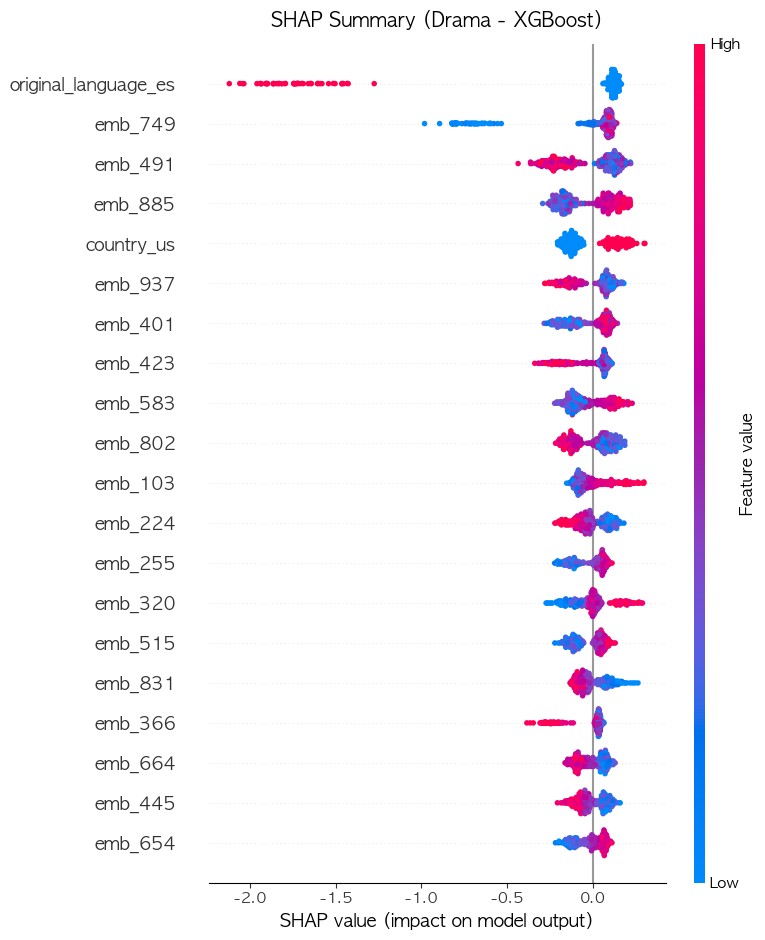

In [25]:
# ============================================================
# 드라마 흥행 예측 모델 (XGBoost)
# ============================================================

print("="*60)
print("드라마 흥행 예측 모델 XGBoost (상위20% vs 하위40%)")
print("="*60)

# 자동으로 클래스 가중치 계산
drama_sample_weights = compute_sample_weight(
    'balanced',
    y=drama_y_train
)

# ============================================================
# XGBoost 학습
# ============================================================
drama_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',        # 이진분류 + 로지스틱 손실함수 (확률 출력)
    n_estimators=5000,                  # 최대 트리 수 (early_stopping으로 자동 조정)
    learning_rate=0.03,                 # 학습률 (작을수록 정밀 학습)
    max_depth=6,                        # 트리 최대 깊이 (모델 복잡도 제어)
    subsample=0.85,                     # 데이터 샘플링 비율 (과적합 방지)
    colsample_bytree=0.85,              # 피처 샘플링 비율 (과적합 방지)
    reg_lambda=1.0,                     # L2 정규화 강도 (과적합 방지)
    random_state=RANDOM_STATE,          # 랜덤 시드 고정 (재현성 보장)
    n_jobs=-1,                          # 모든 CPU 코어 병렬 처리 (속도 최적화)
    eval_metric='auc',                  # 검증 지표 (Valid셋에서 AUC 계산)
    early_stopping_rounds=200           # Valid 성능 200회 악화시 학습 중단
)

drama_xgb_model.fit(
    drama_X_train, drama_y_train,
    eval_set=[(drama_X_valid, drama_y_valid)],
    sample_weight=drama_sample_weights,  # 개별 샘플 단위로 가중치 적용
    verbose=100
)

# ============================================================
# 평가
# ============================================================
drama_xgb_pred_prob = drama_xgb_model.predict_proba(drama_X_valid)[:, 1]
drama_xgb_pred = (drama_xgb_pred_prob >= 0.5).astype(int)

print(f"\n[Drama XGBoost 성능]")
print(f"AUC: {roc_auc_score(drama_y_valid, drama_xgb_pred_prob):.4f}")
print(f"F1: {f1_score(drama_y_valid, drama_xgb_pred):.4f}")

# ============================================================
# XGBoost Threshold 실험 
# ============================================================
print("\n" + "="*60)
print("XGBoost Threshold 실험")
print("="*60)

drama_xgb_best_threshold = 0.5
drama_xgb_best_f1 = 0

for drama_xgb_threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    drama_xgb_pred = (drama_xgb_pred_prob >= drama_xgb_threshold).astype(int)
    
    drama_xgb_f1 = f1_score(drama_y_valid, drama_xgb_pred)
    drama_xgb_precision = precision_score(drama_y_valid, drama_xgb_pred)
    drama_xgb_recall = recall_score(drama_y_valid, drama_xgb_pred)
    
    print(f"\nThreshold: {drama_xgb_threshold}")
    print(f"  Precision: {drama_xgb_precision:.4f}")
    print(f"  Recall: {drama_xgb_recall:.4f}")
    print(f"  F1: {drama_xgb_f1:.4f}")
    
    # 클래스별 성능
    drama_xgb_cm = classification_report(drama_y_valid, drama_xgb_pred, output_dict=True, zero_division=0)
    print(f"  Recall (0): {drama_xgb_cm['0']['recall']:.4f}")
    print(f"  Recall (1): {drama_xgb_cm['1']['recall']:.4f}")
    
    if drama_xgb_f1 > drama_xgb_best_f1:
        drama_xgb_best_f1 = drama_xgb_f1
        drama_xgb_best_threshold = drama_xgb_threshold

print(f"\n최적 Threshold: {drama_xgb_best_threshold} (F1: {drama_xgb_best_f1:.4f})")

# 최적 threshold로 최종 평가
drama_xgb_pred = (drama_xgb_pred_prob >= drama_xgb_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[Drama XGBoost 성능] (Threshold: {drama_xgb_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(drama_y_valid, drama_xgb_pred_prob):.4f}")
print(f"F1 Score: {f1_score(drama_y_valid, drama_xgb_pred):.4f}")
print(f"Precision: {precision_score(drama_y_valid, drama_xgb_pred):.4f}")
print(f"Recall: {recall_score(drama_y_valid, drama_xgb_pred):.4f}")
print("\n", classification_report(drama_y_valid, drama_xgb_pred))

# ============================================================
# Feature Importance
# ============================================================
drama_xgb_imp = pd.DataFrame({
    'feature': drama_X_train.columns,
    'gain': drama_xgb_model.feature_importances_
}).sort_values('gain', ascending=False)

plt.figure(figsize=(10, 7))
plt.barh(drama_xgb_imp.head(20)['feature'][::-1], drama_xgb_imp.head(20)['gain'][::-1])
plt.title('Drama Top 20 Feature Importance (XGBoost)')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

# ============================================================
# SHAP
# ============================================================

drama_xgb_explainer = shap.TreeExplainer(drama_xgb_model)
drama_xgb_shap_values = drama_xgb_explainer.shap_values(drama_X_valid)

# SHAP plot 생성 (show=False로 제목 추가 가능하게)
shap.summary_plot(
    drama_xgb_shap_values, 
    drama_X_valid, 
    max_display=20,
    show=False
)

# 제목 추가
plt.title("SHAP Summary (Drama - XGBoost)", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

### 드라마 흥행 예측 모델 (MLP)

드라마 흥행 예측 모델 MLP (상위20% vs 하위40%)
Iteration 1, loss = 0.63349791
Validation score: 0.681818
Iteration 2, loss = 0.42002133
Validation score: 0.720779
Iteration 3, loss = 0.29775076
Validation score: 0.733766
Iteration 4, loss = 0.20013088
Validation score: 0.714286
Iteration 5, loss = 0.12081112
Validation score: 0.701299
Iteration 6, loss = 0.06131455
Validation score: 0.707792
Iteration 7, loss = 0.02915049
Validation score: 0.688312
Iteration 8, loss = 0.01451261
Validation score: 0.707792
Iteration 9, loss = 0.00714909
Validation score: 0.688312
Iteration 10, loss = 0.00450955
Validation score: 0.688312
Iteration 11, loss = 0.00319568
Validation score: 0.694805
Iteration 12, loss = 0.00252101
Validation score: 0.694805
Iteration 13, loss = 0.00216388
Validation score: 0.688312
Iteration 14, loss = 0.00192295
Validation score: 0.688312
Iteration 15, loss = 0.00176258
Validation score: 0.694805
Iteration 16, loss = 0.00164843
Validation score: 0.694805
Iteration 17, loss = 0.00155776

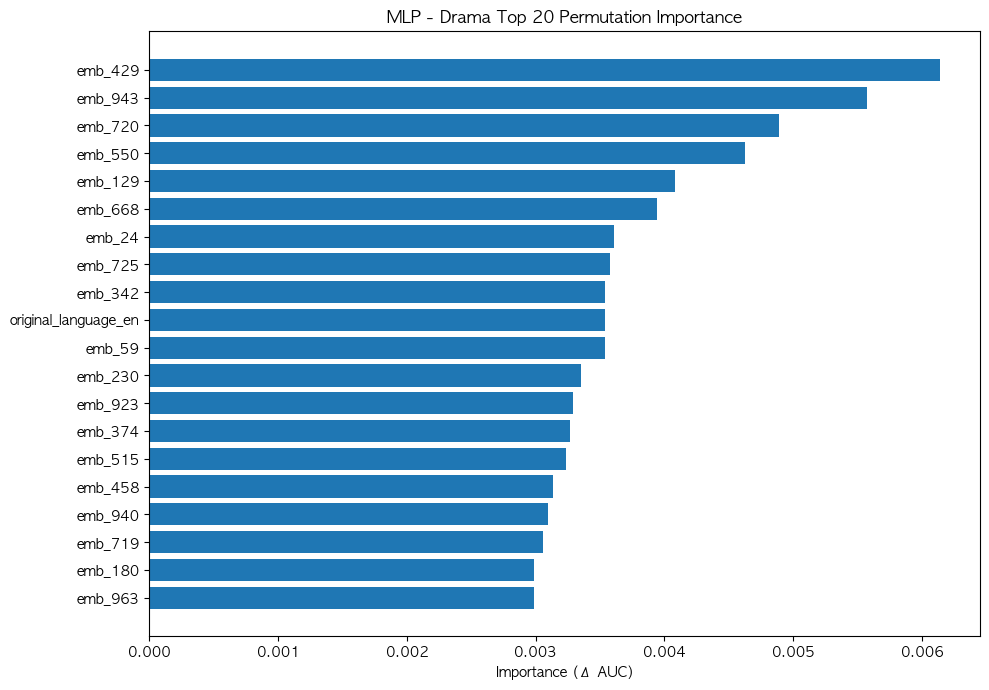


MLP - Drama Top 20 Permutation Importance:
                   feature  importance      group
484                emb_429    0.006143  embedding
998                emb_943    0.005570  embedding
775                emb_720    0.004886  embedding
605                emb_550    0.004625  embedding
184                emb_129    0.004082  embedding
723                emb_668    0.003941  embedding
79                  emb_24    0.003610  embedding
780                emb_725    0.003579  embedding
397                emb_342    0.003539  embedding
9     original_language_en    0.003539   original
114                 emb_59    0.003539  embedding
285                emb_230    0.003348  embedding
978                emb_923    0.003288  embedding
429                emb_374    0.003268  embedding
570                emb_515    0.003238  embedding
513                emb_458    0.003137  embedding
995                emb_940    0.003097  embedding
774                emb_719    0.003057  embedding
235   

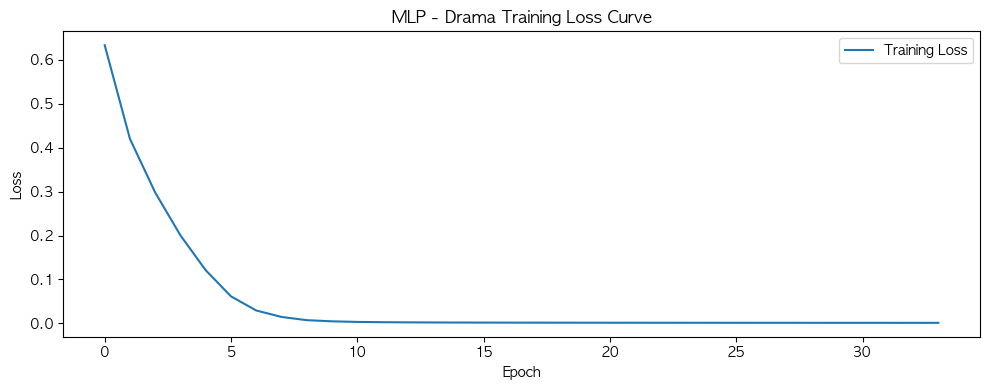

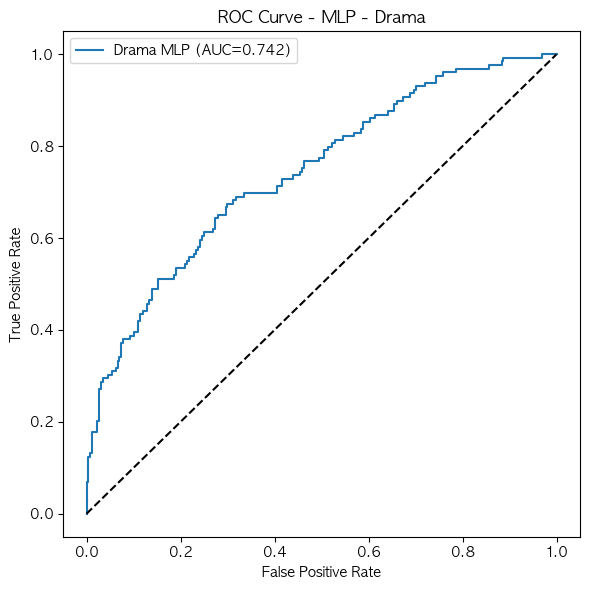

In [26]:
# ============================================================
# 드라마 흥행 예측 모델 (MLP)
# ============================================================

print("="*60)
print("드라마 흥행 예측 모델 MLP (상위20% vs 하위40%)")
print("="*60)

# ============================================================
# 선택적 스케일링
# ============================================================
# 연속형 컬럼만 스케일링: month_sin/cos, 임베딩 (missing flags는 의도적으로 제외 (binary 0/1 값 유지))
drama_continuous_cols = (
    ['month_sin', 'month_cos'] +
    [c for c in drama_X_train.columns if c.startswith('emb_')]
)

drama_scaler = StandardScaler()
drama_X_train_scaled = drama_X_train.copy()
drama_X_valid_scaled = drama_X_valid.copy()

drama_X_train_scaled[drama_continuous_cols] = drama_scaler.fit_transform(drama_X_train[drama_continuous_cols])
drama_X_valid_scaled[drama_continuous_cols] = drama_scaler.transform(drama_X_valid[drama_continuous_cols])

# ============================================================
# 드라마 MLP 학습
# ============================================================
drama_mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),      # 3개 은닉층 구조: 뉴런 (깊은 네트워크)
    activation='relu',                      # 활성화 함수: ReLU (비선형성 부여, 계산 빠름)
    solver='adam',                          # 최적화 알고리즘: Adam (적응적 학습률, 안정적 수렴)
    alpha=0.0005,                           # 약한 정규화
    learning_rate_init=0.0008,              # 초기 학습률 (작을수록 정밀 학습)
    max_iter=500,                           # 최대 학습 반복 횟수
    early_stopping=True,                    # 조기 종료 활성화 (과적합 방지)
    validation_fraction=0.1,                # 학습 데이터의 n%를 내부 검증용으로 분리
    n_iter_no_change=30,                    # 검증 성능 n회 안 좋아지면 조기 종료
    random_state=RANDOM_STATE,              # 랜덤 시드 고정 (재현성 보장)
    verbose=True                            # 학습 과정 상세 로그 출력
)

drama_mlp_model.fit(drama_X_train_scaled, drama_y_train)

# ============================================================
# 평가
# ============================================================
drama_mlp_pred_prob = drama_mlp_model.predict_proba(drama_X_valid_scaled)[:, 1]
drama_mlp_pred = (drama_mlp_pred_prob >= 0.5).astype(int)

print("\n" + "="*60)
print("\n[Drama MLP 성능]")
print("="*60)
print(f"AUC: {roc_auc_score(drama_y_valid, drama_mlp_pred_prob):.4f}")
print(f"F1 Score: {f1_score(drama_y_valid, drama_mlp_pred):.4f}")

# ============================================================
# MLP Threshold 실험 
# ============================================================

print("\n" + "="*60)
print("드라마 MLP Threshold 실험")
print("="*60)

drama_mlp_best_threshold = 0.5
drama_mlp_best_f1 = 0

for drama_mlp_threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    tmp_drama_mlp_pred = (drama_mlp_pred_prob >= drama_mlp_threshold).astype(int)
    drama_mlp_f1 = f1_score(drama_y_valid, tmp_drama_mlp_pred)
    
    print(f"Threshold {drama_mlp_threshold:.1f} | F1: {drama_mlp_f1:.4f}")
    
    if drama_mlp_f1 > drama_mlp_best_f1:
        drama_mlp_best_f1 = drama_mlp_f1
        drama_mlp_best_threshold = drama_mlp_threshold

print(f"\nMLP 최적 Threshold: {drama_mlp_best_threshold} (F1={drama_mlp_best_f1:.4f})")

# 최적 threshold로 재예측
drama_mlp_pred = (drama_mlp_pred_prob >= drama_mlp_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[Drama MLP 성능] (Threshold: {drama_mlp_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(drama_y_valid, drama_mlp_pred_prob):.4f}")
print(f"F1 Score: {f1_score(drama_y_valid, drama_mlp_pred):.4f}")
print(f"Precision: {precision_score(drama_y_valid, drama_mlp_pred):.4f}")
print(f"Recall: {recall_score(drama_y_valid, drama_mlp_pred):.4f}")
print("\n", classification_report(drama_y_valid, drama_mlp_pred))

# ============================================================
# Permutation Importance
# ============================================================

drama_mlp_result = permutation_importance(
    drama_mlp_model,  # 학습된 모델 직접 사용
    drama_X_valid_scaled,   # 스케일된 데이터
    drama_y_valid,
    n_repeats=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="roc_auc"
)

drama_mlp_perm_imp = (
    pd.DataFrame({
        "feature": drama_X_valid.columns,
        "importance": drama_mlp_result.importances_mean
    })
    .sort_values("importance", ascending=False)
)

# ============================================================
# Feature Group 생성
# ============================================================
drama_mlp_perm_imp["group"] = np.where(
    drama_mlp_perm_imp["feature"].str.startswith("emb_"),
    "embedding",
    drama_mlp_perm_imp["feature"].str.split("_").str[0]
)

drama_mlp_group_imp = (
    drama_mlp_perm_imp.groupby("group")["importance"]
    .sum()
    .sort_values(ascending=False)
)

# ============================================================
# Top 20 그래프 출력
# ============================================================
plt.figure(figsize=(10, 7))
plt.barh(
    drama_mlp_perm_imp.head(20)["feature"][::-1],
    drama_mlp_perm_imp.head(20)["importance"][::-1]
)
plt.title("MLP - Drama Top 20 Permutation Importance")
plt.xlabel("Importance (Δ AUC)")
plt.tight_layout()
plt.show()

# ============================================================
# Top 20 텍스트 출력
# ============================================================
print("\nMLP - Drama Top 20 Permutation Importance:")
print(drama_mlp_perm_imp.head(20))

print("\n[Permutation Importance by Feature Group]")
print(drama_mlp_group_imp)

# ============================================================
# 학습 곡선
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(drama_mlp_model.loss_curve_, label="Training Loss")
plt.title("MLP - Drama Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# ROC Curve
# ============================================================
drama_mlp_fpr, drama_mlp_tpr, _ = roc_curve(drama_y_valid, drama_mlp_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(drama_mlp_fpr, drama_mlp_tpr, label=f"Drama MLP (AUC={roc_auc_score(drama_y_valid, drama_mlp_pred_prob):.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP - Drama")
plt.legend()
plt.tight_layout()
plt.show()

### 드라마 흥행 예측 앙상블 모델 (LightGBM + XGBoost + MLP)

드라마 흥행 예측 - 앙상블 모델 (LightGBM + XGBoost + MLP)

[Ensemble (평균) - default threshold=0.5]
AUC: 0.7685
F1 Score: 0.5196
Precision: 0.7067
Recall: 0.4109

               precision    recall  f1-score   support

           0       0.76      0.91      0.83       257
           1       0.71      0.41      0.52       129

    accuracy                           0.75       386
   macro avg       0.73      0.66      0.67       386
weighted avg       0.74      0.75      0.72       386


앙상블 Threshold 실험
[BEST UPDATE] t=0.05 | F1=0.5328 | P=0.3663 | R=0.9767
[BEST UPDATE] t=0.06 | F1=0.5368 | P=0.3724 | R=0.9612
[BEST UPDATE] t=0.07 | F1=0.5430 | P=0.3796 | R=0.9535
[BEST UPDATE] t=0.09 | F1=0.5517 | P=0.3922 | R=0.9302
[BEST UPDATE] t=0.10 | F1=0.5535 | P=0.3953 | R=0.9225
[BEST UPDATE] t=0.12 | F1=0.5571 | P=0.4021 | R=0.9070
[BEST UPDATE] t=0.13 | F1=0.5652 | P=0.4105 | R=0.9070
[BEST UPDATE] t=0.14 | F1=0.5721 | P=0.4212 | R=0.8915
[BEST UPDATE] t=0.15 | F1=0.5808 | P=0.4307 | R=0.8915
[BEST UPD

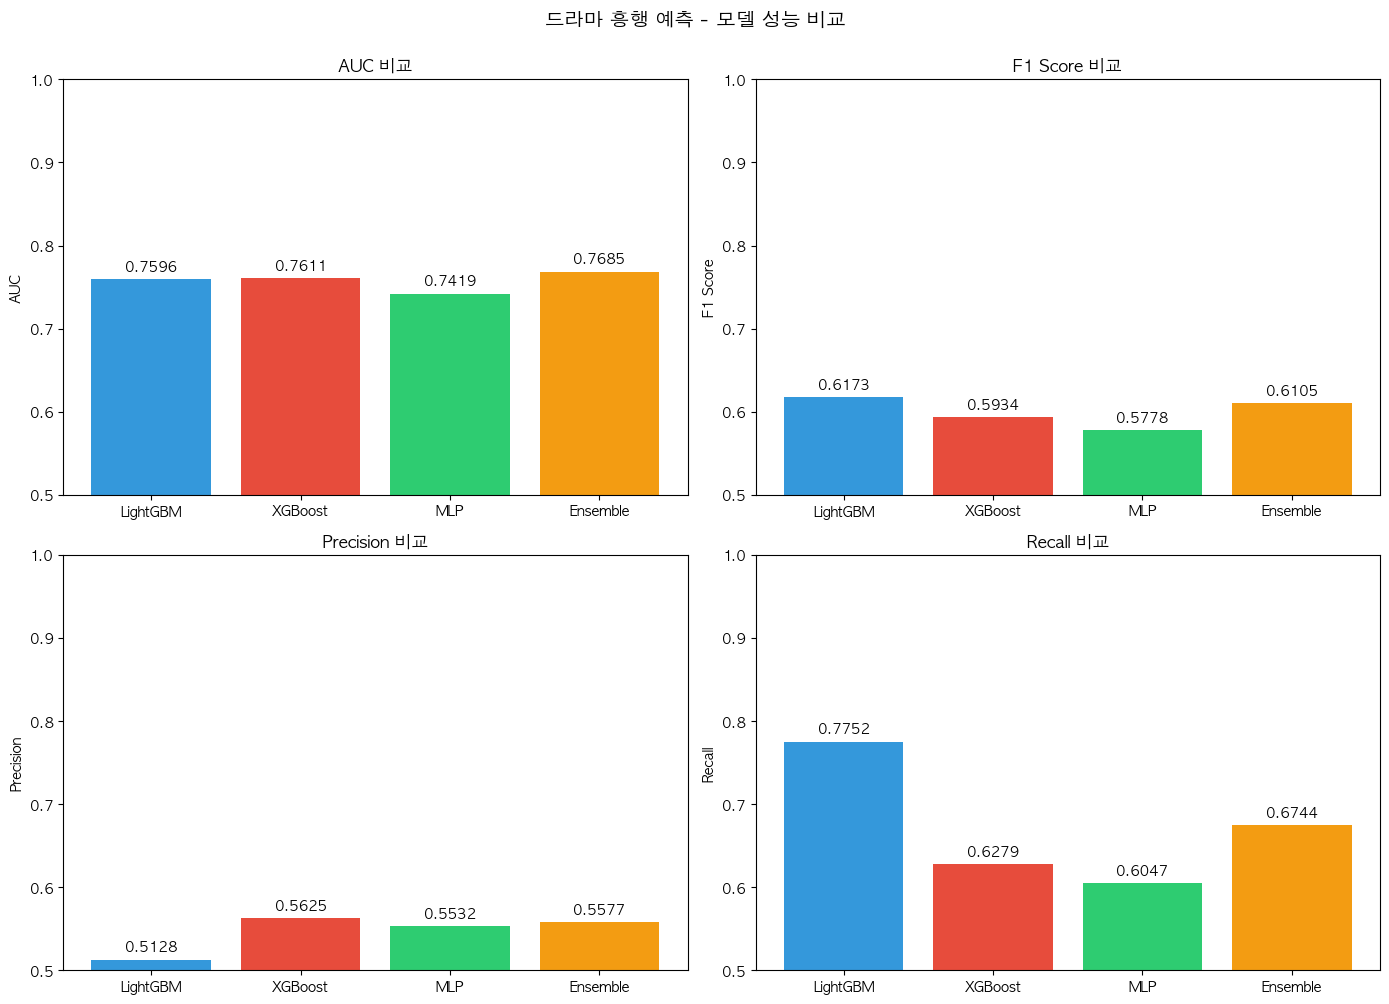

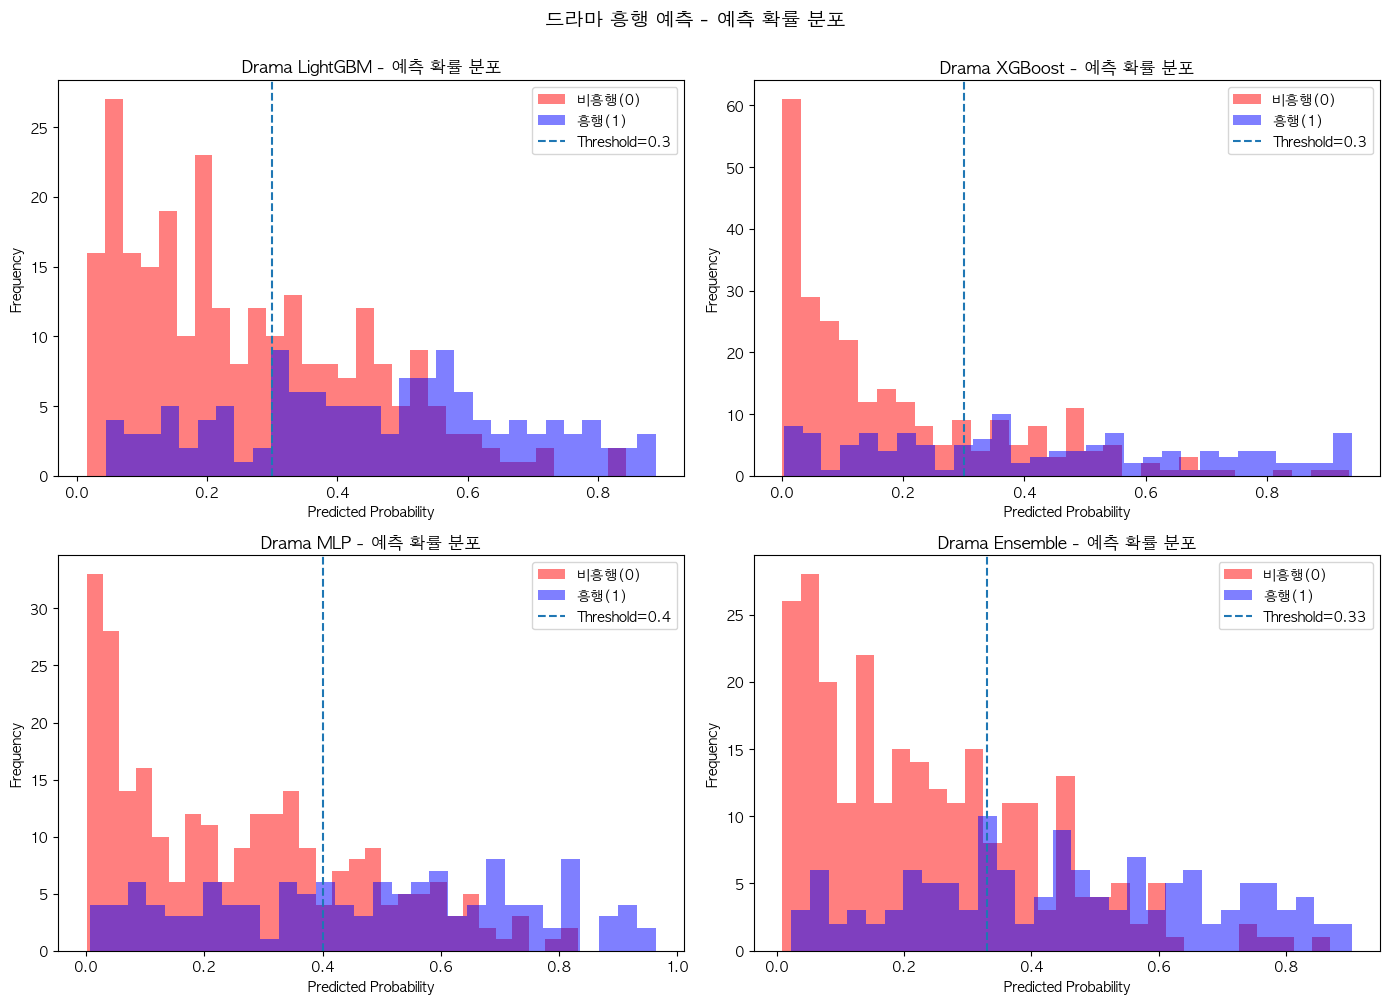

3개 모델 모두 동의(완전 일치): 68.9%
다수결 예측 정확도(majority vs True): 69.4%
앙상블 vs 다수결 일치율: 94.6%
Pairwise agreement - LGB/XGB: 84.7% | LGB/MLP: 76.7% | XGB/MLP: 76.4%


In [27]:
# ============================================================
# 드라마 흥행 예측 앙상블 모델: 확률 평균 + Threshold 최적화
# ============================================================
print("="*60)
print("드라마 흥행 예측 - 앙상블 모델 (LightGBM + XGBoost + MLP)")
print("="*60)

# ------------------------------------------------------------
# 1) 앙상블 확률: 3개 모델의 예측 확률을 단순 평균
# ------------------------------------------------------------
drama_ensemble_pred_prob = (drama_lgb_pred_prob + drama_xgb_pred_prob + drama_mlp_pred_prob) / 3

# ------------------------------------------------------------
# 2) 기본 Threshold(0.5)로 “참고용” 성능 출력
# - AUC는 threshold 없이 확률로 계산되므로 여기서 가장 의미 있음
# - Precision/Recall/F1은 threshold에 따라 크게 변하므로 아래에서 최적화
# ------------------------------------------------------------
default_thr = 0.5
drama_ensemble_pred_default = (drama_ensemble_pred_prob >= default_thr).astype(int)

print(f"\n[Ensemble (평균) - default threshold={default_thr}]")
print(f"AUC: {roc_auc_score(drama_y_valid, drama_ensemble_pred_prob):.4f}")  # 확률 기반 지표
print(f"F1 Score: {f1_score(drama_y_valid, drama_ensemble_pred_default):.4f}")
print(f"Precision: {precision_score(drama_y_valid, drama_ensemble_pred_default, zero_division=0):.4f}")
print(f"Recall: {recall_score(drama_y_valid, drama_ensemble_pred_default):.4f}")
print("\n", classification_report(drama_y_valid, drama_ensemble_pred_default, zero_division=0))

# ============================================================
# 3) Threshold 실험: F1 최대가 되는 threshold 찾기
# ============================================================
print("\n" + "="*60)
print("앙상블 Threshold 실험")
print("="*60)

# best 값 초기화
drama_ensemble_best_threshold = None
drama_ensemble_best_f1 = -1.0
drama_ensemble_best_precision = None
drama_ensemble_best_recall = None

# threshold grid: 0.05 ~ 0.95까지 0.01 간격
thr_grid = np.round(np.arange(0.05, 0.96, 0.01), 2)

for drama_ensemble_t in thr_grid:
    # t 기준으로 이진 예측 생성
    tmp_drama_ensemble_pred = (drama_ensemble_pred_prob >= drama_ensemble_t).astype(int)
    
    # 양성 예측 0개면 precision 0/0 상황 발생 가능 → 스킵
    if tmp_drama_ensemble_pred.sum() == 0:
        continue
        
    # metric 계산
    tmp_drama_ensemble_f1 = f1_score(drama_y_valid, tmp_drama_ensemble_pred)
    tmp_drama_ensemble_precision = precision_score(drama_y_valid, tmp_drama_ensemble_pred, zero_division=0)
    tmp_drama_ensemble_recall = recall_score(drama_y_valid, tmp_drama_ensemble_pred)
    
    # best 갱신 로직이 없으면 best_threshold가 끝까지 None이 됨
    if tmp_drama_ensemble_f1 > drama_ensemble_best_f1:
        drama_ensemble_best_f1 = tmp_drama_ensemble_f1
        drama_ensemble_best_threshold = drama_ensemble_t
        drama_ensemble_best_precision = tmp_drama_ensemble_precision
        drama_ensemble_best_recall = tmp_drama_ensemble_recall
        
        # best가 바뀔 때만 로그 출력
        print(
            f"[BEST UPDATE] t={drama_ensemble_t:.2f} | F1={drama_ensemble_best_f1:.4f} | " 
            f"P={drama_ensemble_best_precision:.4f} | R={drama_ensemble_best_recall:.4f}"
        )

# best가 못 잡힌 경우 fallback
if drama_ensemble_best_threshold is None:
    drama_ensemble_best_threshold = default_thr
    drama_ensemble_best_f1 = f1_score(drama_y_valid, drama_ensemble_pred_default)
    drama_ensemble_best_precision = precision_score(drama_y_valid, drama_ensemble_pred_default, zero_division=0)
    drama_ensemble_best_recall = recall_score(drama_y_valid, drama_ensemble_pred_default)

print("\n" + "-" * 60)
print(f"최적 Threshold: {drama_ensemble_best_threshold} "
      f"(F1: {drama_ensemble_best_f1:.4f}, "
      f"P: {drama_ensemble_best_precision:.4f}, "
      f"R: {drama_ensemble_best_recall:.4f})")
print("-" * 60)

# ============================================================
# 4) 최적 threshold로 최종 앙상블 평가
# ============================================================
drama_ensemble_pred_final = (drama_ensemble_pred_prob >= drama_ensemble_best_threshold).astype(int)

print("\n" + "="*60)
print(f"[드라마 Ensemble 성능] (Threshold: {drama_ensemble_best_threshold})")
print("="*60)
print(f"AUC: {roc_auc_score(drama_y_valid, drama_ensemble_pred_prob):.4f}")
print(f"F1 Score: {f1_score(drama_y_valid, drama_ensemble_pred_final):.4f}")
print(f"Precision: {precision_score(drama_y_valid, drama_ensemble_pred_final, zero_division=0):.4f}")
print(f"Recall: {recall_score(drama_y_valid, drama_ensemble_pred_final):.4f}")
print("\n", classification_report(drama_y_valid, drama_ensemble_pred_final, zero_division=0))

# 모델별 "각자 best_threshold"로 고정 pred 만들어 비교 테이블에 넣기
drama_lgb_pred_final = (drama_lgb_pred_prob >= drama_lgb_best_threshold).astype(int)
drama_xgb_pred_final = (drama_xgb_pred_prob >= drama_xgb_best_threshold).astype(int)
drama_mlp_pred_final = (drama_mlp_pred_prob >= drama_mlp_best_threshold).astype(int)

# ============================================================
# 5) 성능 비교표
# ============================================================
drama_results = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'MLP', 'Ensemble'],
    'Threshold': [drama_lgb_best_threshold, drama_xgb_best_threshold, drama_mlp_best_threshold, drama_ensemble_best_threshold],
    'AUC': [
        roc_auc_score(drama_y_valid, drama_lgb_pred_prob),
        roc_auc_score(drama_y_valid, drama_xgb_pred_prob),
        roc_auc_score(drama_y_valid, drama_mlp_pred_prob),
        roc_auc_score(drama_y_valid, drama_ensemble_pred_prob)
    ],
    'F1': [
        f1_score(drama_y_valid, drama_lgb_pred_final),
        f1_score(drama_y_valid, drama_xgb_pred_final),
        f1_score(drama_y_valid, drama_mlp_pred_final),
        f1_score(drama_y_valid, drama_ensemble_pred_final)
    ],
    'Precision': [
        precision_score(drama_y_valid, drama_lgb_pred_final, zero_division=0),
        precision_score(drama_y_valid, drama_xgb_pred_final, zero_division=0),
        precision_score(drama_y_valid, drama_mlp_pred_final, zero_division=0),
        precision_score(drama_y_valid, drama_ensemble_pred_final, zero_division=0)
    ],
    'Recall': [
        recall_score(drama_y_valid, drama_lgb_pred_final),
        recall_score(drama_y_valid, drama_xgb_pred_final),
        recall_score(drama_y_valid, drama_mlp_pred_final),
        recall_score(drama_y_valid, drama_ensemble_pred_final)
    ]
})

print("\n" + "="*60)
print("모델 성능 비교")
print("="*60)
print(drama_results.to_string(index=False))

# ============================================================
# 6) 시각화: 모델 성능 비교
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# AUC
axes[0, 0].bar(drama_results['Model'], drama_results['AUC'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[0, 0].set_title('AUC 비교', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('AUC')
axes[0, 0].set_ylim([0.5, 1.0])
for i, v in enumerate(drama_results['AUC']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# F1 Score
axes[0, 1].bar(drama_results['Model'], drama_results['F1'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[0, 1].set_title('F1 Score 비교', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_ylim([0.5, 1.0])
for i, v in enumerate(drama_results['F1']):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# Precision
axes[1, 0].bar(drama_results['Model'], drama_results['Precision'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[1, 0].set_title('Precision 비교', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_ylim([0.5, 1.0])
for i, v in enumerate(drama_results['Precision']):
    axes[1, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

# Recall
axes[1, 1].bar(drama_results['Model'], drama_results['Recall'], color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
axes[1, 1].set_title('Recall 비교', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_ylim([0.5, 1.0])
for i, v in enumerate(drama_results['Recall']):
    axes[1, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.suptitle('드라마 흥행 예측 - 모델 성능 비교', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============================================================
# 예측 확률 분포
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

drama_plot_items = [
    ("Drama LightGBM", drama_lgb_pred_prob, drama_lgb_best_threshold),
    ("Drama XGBoost",  drama_xgb_pred_prob, drama_xgb_best_threshold),
    ("Drama MLP",      drama_mlp_pred_prob, drama_mlp_best_threshold),
    ("Drama Ensemble", drama_ensemble_pred_prob, drama_ensemble_best_threshold),
]

for idx, (name, probs, thr) in enumerate(drama_plot_items):
    ax = axes[idx // 2, idx % 2]
    ax.hist(probs[drama_y_valid == 0], bins=30, alpha=0.5, label="비흥행(0)", color="red")
    ax.hist(probs[drama_y_valid == 1], bins=30, alpha=0.5, label="흥행(1)", color="blue")
    ax.axvline(thr, linestyle="--", label=f"Threshold={thr}")
    ax.set_title(f"{name} - 예측 확률 분포", fontweight="bold")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.suptitle("드라마 흥행 예측 - 예측 확률 분포", fontsize=14, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

# ============================================================
# 7) 모델 간 예측 일치도 (agreement)
#    - agreement는 같은 threshold 기준에서 비교해야 의미가 있으므로
#      앙상블 최적 threshold를 공통 기준으로 사용
# ============================================================

drama_common_thr = drama_ensemble_best_threshold

# 3개 베이스 모델의 이진 예측 (공통 threshold로 통일)
drama_base_pred_df = pd.DataFrame({
    "LightGBM": (drama_lgb_pred_prob >= drama_common_thr).astype(int),
    "XGBoost":  (drama_xgb_pred_prob >= drama_common_thr).astype(int),
    "MLP":      (drama_mlp_pred_prob >= drama_common_thr).astype(int),
})

# 1) 3개 모델 '완전 일치' 비율 (의견이 전부 같음)
drama_all_agree = (drama_base_pred_df.nunique(axis=1) == 1)   # 각 행에서 유니크 값 개수가 1이면 3개가 동일
print(f"3개 모델 모두 동의(완전 일치): {drama_all_agree.mean() * 100:.1f}%")

# 2) 다수결(majority vote) 예측 + 다수결 정확도(=정답과 일치한 비율)
drama_majority_pred = (drama_base_pred_df.sum(axis=1) >= 2).astype(int)  # 1이 2개 이상이면 1
drama_majority_acc = (drama_majority_pred.values == np.asarray(drama_y_valid)).mean()
print(f"다수결 예측 정확도(majority vs True): {drama_majority_acc * 100:.1f}%")

# 3) 앙상블(확률 평균) 이진 예측이 다수결과 얼마나 같은지
drama_ensemble_pred_common = (drama_ensemble_pred_prob >= drama_common_thr).astype(int)
drama_ensemble_vs_majority = (drama_ensemble_pred_common == drama_majority_pred.values).mean()
print(f"앙상블 vs 다수결 일치율: {drama_ensemble_vs_majority * 100:.1f}%")

# 4) 참고: 쌍별(pairwise) 일치율
drama_pair_lgb_xgb = (drama_base_pred_df["LightGBM"] == drama_base_pred_df["XGBoost"]).mean()
drama_pair_lgb_mlp = (drama_base_pred_df["LightGBM"] == drama_base_pred_df["MLP"]).mean()
drama_pair_xgb_mlp = (drama_base_pred_df["XGBoost"] == drama_base_pred_df["MLP"]).mean()
print(f"Pairwise agreement - LGB/XGB: {drama_pair_lgb_xgb * 100:.1f}% | "
      f"LGB/MLP: {drama_pair_lgb_mlp * 100:.1f}% | XGB/MLP: {drama_pair_xgb_mlp * 100:.1f}%")

## 영화·드라마 흥행 예측 모델 종합 분석


## Streamlit용 파일 만들기

✅ 모델 예측용 데이터 / 추천용 데이터 완전 분리

✅ 추천 DB에는 가벼운 메타만 유지

✅ imdb_id 기준 단방향 join → 데이터 오염 없음

✅ Chroma rebuild 안전

✅ Streamlit은 DB를 “읽기 전용”으로만 사용

✅ cosine 기반이라 설명 가능성 높음

| 구분                        | 역할                                   |
| ------------------------- | ------------------------------------ |
| `save_models_and_data.py` | 예측/시뮬레이션용 (메타 데이터 + 예측 모델)     |
| `save_emb.py`             | 유사 콘텐츠 추천용 (임베딩 + ChromaDB) |


### 대시보드 - 시뮬레이션용 파일 생성

In [34]:
# save_models_and_data
"""
시뮬레이션/예측/분석용 학습된 모델과 데이터를 저장하는 스크립트
    - models 폴더: 모델, scaler, feature schema, hit_label 포함 CSV 생성
    - data 폴더: 메타 정보만 저장, 임베딩/인코딩 등 불필요 컬럼 제외
"""

import os
import joblib
import pandas as pd
import pickle
import numpy as np

# ============================================================
# 경로 설정
# ============================================================

# 현재 작업 디렉토리 기준 경로 (노트북 실행 위치)
DASHBOARD_DIR = "dashboard"
MODELS_DIR = os.path.join(DASHBOARD_DIR, "models")
DATA_DIR = os.path.join(DASHBOARD_DIR, "data")

# 원본 데이터 경로 (현재 위치 기준)
SOURCE_DATA_DIR = "dataset"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print("✅ 폴더 생성 완료!")
print(f"   - 모델 저장 경로: {MODELS_DIR}")
print(f"   - 데이터 저장 경로: {DATA_DIR}")

# ============================================================
# 1) 모델 저장
# ============================================================
print("모델 저장 중...")

# 영화 모델
joblib.dump(movie_lgb_model, os.path.join(MODELS_DIR, 'movie_lgb_model.joblib'))
joblib.dump(movie_xgb_model, os.path.join(MODELS_DIR, 'movie_xgb_model.joblib'))
joblib.dump(movie_mlp_model, os.path.join(MODELS_DIR, 'movie_mlp_model.joblib'))
joblib.dump(movie_scaler,   os.path.join(MODELS_DIR, 'movie_scaler.joblib'))

joblib.dump(drama_lgb_model, os.path.join(MODELS_DIR, 'drama_lgb_model.joblib'))
joblib.dump(drama_xgb_model, os.path.join(MODELS_DIR, 'drama_xgb_model.joblib'))
joblib.dump(drama_mlp_model, os.path.join(MODELS_DIR, 'drama_mlp_model.joblib'))
joblib.dump(drama_scaler,    os.path.join(MODELS_DIR, 'drama_scaler.joblib'))

print("✅ 모델 저장 완료!")

# ============================================================
# 2) 피처 컬럼 정보 저장
# ============================================================
print("\n피처 컬럼 정보 저장 중...")

# 영화 피처 컬럼
movie_feature_info = {
    'all_columns': movie_X_train.columns.tolist(),
    'continuous_cols': movie_continuous_cols,
    'genre_cols': [c for c in movie_X_train.columns if c.startswith('genre_')],
    'country_cols': [c for c in movie_X_train.columns if c.startswith('country_')],
    'language_cols': [c for c in movie_X_train.columns if c.startswith('original_language_')],
    'thresholds': {
        'lgb': movie_lgb_best_threshold,
        'xgb': movie_xgb_best_threshold,
        'mlp': movie_mlp_best_threshold,
        'ensemble': movie_ensemble_best_threshold
    }
}

with open(os.path.join(DATA_DIR, 'movie_feature_columns.pkl'), 'wb') as f:
    pickle.dump(movie_feature_info, f)

# 드라마 피처 컬럼
drama_feature_info = {
    'all_columns': drama_X_train.columns.tolist(),
    'continuous_cols': drama_continuous_cols,
    'genre_cols': [c for c in drama_X_train.columns if c.startswith('genre_')],
    'country_cols': [c for c in drama_X_train.columns if c.startswith('country_')],
    'language_cols': [c for c in drama_X_train.columns if c.startswith('original_language_')],
    'thresholds': {
        'lgb': drama_lgb_best_threshold,
        'xgb': drama_xgb_best_threshold,
        'mlp': drama_mlp_best_threshold,
        'ensemble': drama_ensemble_best_threshold
    }
}

with open(os.path.join(DATA_DIR, 'drama_feature_columns.pkl'), 'wb') as f:
    pickle.dump(drama_feature_info, f)

print("✅ 피처 컬럼 정보 저장 완료!")

# ============================================================
# 3) 데이터 저장 함수
# ============================================================

def export_dashboard_csv(
    merged_df,
    main_df,
    genre_df,
    country_df,
    date_col,
    out_path
):
    df = merged_df.copy()

    # 메인 메타
    df = df.merge(
        main_df[['imdb_id', 'title', date_col, 'original_language', 'poster_path']],
        on='imdb_id',
        how='left'
    )

    # 장르
    genres = (
        genre_df
        .groupby('imdb_id')['genre']
        .apply(', '.join)
        .reset_index(name='genres')
    )

    # 국가 (컬럼명 안전 처리)
    country_col = [c for c in country_df.columns if c != 'imdb_id'][0]
    countries = (
        country_df
        .groupby('imdb_id')[country_col]
        .apply(', '.join)
        .reset_index(name='countries')
    )

    df = df.merge(genres, on='imdb_id', how='left')
    df = df.merge(countries, on='imdb_id', how='left')

    # hit label
    if 'y' in df.columns:
        df['hit_label'] = df['y'].map({1: 'hit', 0: 'flop'})

    # 불필요 컬럼 제거
    df = df.drop(
        columns=[
            c for c in df.columns
            if c.startswith((
                'emb_',
                'genre_',
                'country_',
                'original_language_'
            )) or c in [
                'y',
                'month_sin',
                'month_cos',
                'embedding_missing',
                'runtime_missing'
            ]
        ],
        errors='ignore'
    )

    df.to_csv(out_path, index=False)
    print(f"✅ saved: {out_path} ({df.shape})")

# ------------------------------------------------------------
# 영화 데이터 저장
# ------------------------------------------------------------
export_dashboard_csv(
    movie_merged,
    pd.read_parquet("dataset/00_movie_main.parquet"),
    pd.read_parquet("dataset/02_movie_genre.parquet"),
    pd.read_parquet("dataset/04_movie_country.parquet"),
    "release_date",
    "dashboard/data/movie_data.csv"
)

movie_data = pd.read_csv('dashboard/data/movie_data.csv')
print(f"✅ 영화 데이터 저장 완료! ({len(movie_data)}개)")
print(f"   - 컬럼 수: {len(movie_data.columns)}개 (임베딩, 인코딩 제외)")

# ------------------------------------------------------------
# 드라마 데이터 저장
# ------------------------------------------------------------
export_dashboard_csv(
    drama_merged,
    pd.read_parquet("dataset/00_drama_main.parquet"),
    pd.read_parquet("dataset/01_drama_genre.parquet"),
    pd.read_parquet("dataset/02_drama_country.parquet"),
    "first_air_date",
    "dashboard/data/drama_data.csv"
)

drama_data = pd.read_csv('dashboard/data/drama_data.csv')
print(f"✅ 드라마 데이터 저장 완료! ({len(drama_data)}개)")
print(f"   - 컬럼 수: {len(drama_data.columns)}개 (임베딩, 인코딩 제외)")

✅ 폴더 생성 완료!
   - 모델 저장 경로: dashboard/models
   - 데이터 저장 경로: dashboard/data
모델 저장 중...
✅ 모델 저장 완료!

피처 컬럼 정보 저장 중...
✅ 피처 컬럼 정보 저장 완료!
✅ saved: dashboard/data/movie_data.csv ((15638, 9))
✅ 영화 데이터 저장 완료! (15638개)
   - 컬럼 수: 9개 (임베딩, 인코딩 제외)
✅ saved: dashboard/data/drama_data.csv ((1926, 8))
✅ 드라마 데이터 저장 완료! (1926개)
   - 컬럼 수: 8개 (임베딩, 인코딩 제외)


In [35]:
movie_data.columns

Index(['imdb_id', 'runtime', 'title', 'release_date', 'original_language',
       'poster_path', 'genres', 'countries', 'hit_label'],
      dtype='object')

In [36]:
drama_data.columns

Index(['imdb_id', 'title', 'first_air_date', 'original_language',
       'poster_path', 'genres', 'countries', 'hit_label'],
      dtype='object')

In [37]:
movie_data

,imdb_id,runtime,title,release_date,original_language,poster_path,genres,countries,hit_label
0,tt0444346,83,Flesh for Sale,2005-01-01,es,/oPrRaowFYtqBhBON9yzshnlOKof.jpg,Documentary,NaN,flop
1,tt0398378,84,Vampires: The Turning,2005-01-02,en,/90sY8r0w8W3gwbP2PdkpD7qF2sT.jpg,"Action, Adventure, Horror","other, united states of america",flop
2,tt0443590,70,Mucha Lucha: The Return of El Malefico,2005-01-04,en,/5rKLz9X8ZOT6CJtf4jNpWYSVNPK.jpg,"Adventure, Animation, Action","other, united states of america",flop
3,tt0376105,102,Racing Stripes,2005-01-06,en,/epDsuf5oUdzTFYHqV2IRcyy8Rwc.jpg,"Comedy, Family",united states of america,hit
4,tt0375210,101,White Noise,2005-01-07,en,/ncB9SvOclmXYALlcAsF1jRIuISl.jpg,"Drama, Horror, Thriller","canada, united kingdom, united states of america",flop
...,...,...,...,...,...,...,...,...,...
15633,tt4712810,112,Now You See Me: Now You Don't,2025-11-12,en,/oD3Eey4e4Z259XLm3eD3WGcoJAh.jpg,"Thriller, Crime, Mystery",united states of america,flop
15634,tt35669044,117,Tee Yai: Born to Be Bad,2025-11-12,xx,/ig00LBM2rv4fmCJOPATyRWOJnlL.jpg,"Crime, Action, Drama",other,flop
15635,tt34992378,91,A Merry Little Ex-Mas,2025-11-12,en,/w4ytu75uJ1b0AgPd0wLm7iZMsWJ.jpg,"Romance, Comedy",united states of america,flop
15636,tt19847976,137,Wicked: For Good,2025-11-19,en,/si9tolnefLSUKaqQEGz1bWArOaL.jpg,"Fantasy, Adventure, Romance",united states of america,hit


In [38]:
drama_data

,imdb_id,title,first_air_date,original_language,poster_path,genres,countries,hit_label
0,tt0439100,Weeds,2005-08-07,en,/gKUsBTa5b0GY7U4iWBseeBalfjO.jpg,"Comedy, Crime, Drama",us,hit
1,tt0772137,The Game,2006-10-01,en,/zmvRaCRcmi6lsriYxZmAR6uWHPS.jpg,"Drama, Comedy",us,flop
2,tt0435576,Point Pleasant,2005-01-19,en,/hwVJnaxrC6GPLISLrcLEICurKH9.jpg,"Mystery, Crime, Drama, Soap",us,flop
3,tt0805663,Jericho,2006-09-20,en,/a57H9UsS388Av2LSLKO9inNmY7j.jpg,"Action & Adventure, Drama, Mystery, Western",us,hit
4,tt0840196,Skins,2007-01-25,en,/yaDeFXW7Lzv6fqGymsUctt1a5fs.jpg,"Drama, Comedy",gb,hit
...,...,...,...,...,...,...,...,...
1921,tt35836959,Medusa,2025-03-05,es,/mFsjwJdNBKDRYLqPdBFaoVCKXLq.jpg,Drama,co,flop
1922,tt37504309,Unspeakable Sins,2025-07-30,es,/30eSqR2XPGz53eGElt6YAvH7cPX.jpg,Drama,mx,flop
1923,tt28243363,Sara - Woman in the Shadows,2025-06-03,it,/9QVSjcrWGjV46DlSLfh9JI4oIaa.jpg,"Mystery, Drama, Crime",other,flop
1924,tt37370861,Revenged Love,2025-06-16,zh,/j5KWzpPAi4JC42GGrVWDFL6G2gY.jpg,"Drama, Action & Adventure",cn,hit


### 대시보드 - 유사 흥행작 추천용 파일 생성

#### (1) 임베딩 분리

In [39]:
# save_emb
"""
save_emb.py
유사 흥행작 추천용 데이터를 저장하는 스크립트
    - 임베딩 저장하여 Chroma 벡터 DB 구축 재료로 사용
"""

import os
import pandas as pd
import numpy as np

# ============================================================
# 경로 설정
# ============================================================

# 현재 작업 디렉토리 기준 경로 (노트북 실행 위치)
DASHBOARD_DIR = "dashboard"
MODELS_DIR = os.path.join(DASHBOARD_DIR, "models")
DATA_DIR = os.path.join(DASHBOARD_DIR, "data")

# 원본 데이터 경로 (현재 위치 기준)
SOURCE_DATA_DIR = "dataset"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print("✅ 폴더 생성 완료!")
print(f"   - 모델 저장 경로: {MODELS_DIR}")
print(f"   - 데이터 저장 경로: {DATA_DIR}")
            
# ------------------------------------------------------------
# 영화 데이터
# ------------------------------------------------------------
try:
    
    # imdb_id 중복 제거
    movie_recommender_data = movie_merged.drop_duplicates("imdb_id").copy()
    
    # 임베딩 컬럼 분리 저장
    emb_cols = [c for c in movie_recommender_data.columns if c.startswith('emb_')]
    
    if emb_cols:
        movie_embeddings = movie_recommender_data[['imdb_id'] + emb_cols].copy()

        # 임베딩을 numpy array로 변환하여 저장
        emb_matrix = movie_embeddings[emb_cols].values
        
        # imdb_id 순서 저장
        np.save(
            os.path.join(DATA_DIR, "movie_emb_bundle.npy"),
            {
                "imdb_id": movie_embeddings["imdb_id"].values,
                "embeddings": emb_matrix
            }
        )
  
        print(f"✅ 영화 임베딩 저장 완료: {emb_matrix.shape}")
        
except Exception as e:
    print(f"❌ 영화 임베딩 저장 실패: {e}")


# ------------------------------------------------------------
# 드라마 데이터
# ------------------------------------------------------------
try:
    
    # imdb_id 중복 제거
    drama_recommender_data = drama_merged.drop_duplicates("imdb_id").copy()
        
    # 임베딩 컬럼 분리 저장
    emb_cols = [c for c in drama_recommender_data.columns if c.startswith('emb_')]
    
    if emb_cols:
        drama_embeddings = drama_recommender_data[['imdb_id'] + emb_cols].copy()

        # 임베딩을 numpy array로 변환하여 저장
        emb_matrix = drama_embeddings[emb_cols].values
        
        # imdb_id 순서 저장
        np.save(
            os.path.join(DATA_DIR, "drama_emb_bundle.npy"),
            {
                "imdb_id": drama_embeddings["imdb_id"].values,
                "embeddings": emb_matrix
            }
        )
                
        print(f"✅ 드라마 임베딩 저장 완료: {emb_matrix.shape}")
        
except Exception as e:
    print(f"❌ 드라마 임베딩 저장 실패: {e}")

✅ 폴더 생성 완료!
   - 모델 저장 경로: dashboard/models
   - 데이터 저장 경로: dashboard/data
✅ 영화 임베딩 저장 완료: (15638, 1024)
✅ 드라마 임베딩 저장 완료: (1926, 1024)


#### (2) Chroma 벡터 DB 구축 + 추천 로직 검증

In [45]:
# save_Chroma_DB
""" Chroma 벡터 DB 구축 스크립트 
- save_emb.py 에서 저장한 임베딩(.npy) + 메타 CSV를 사용 
- imdb_id 기준으로 안전하게 매칭 
- 추천용 cosine similarity 벡터 DB 생성 
"""

import os
import numpy as np
import pandas as pd
import chromadb

# ============================================================ 
# 경로 설정 
# ============================================================
DATA_DIR = "dashboard/data"
DB_DIR = "dashboard/chroma_db"

# ChromaDB Persistent Client (디스크 저장)
client = chromadb.PersistentClient(path=DB_DIR)

# ============================================================ 
# Chroma Collection 생성 함수 
# - Chroma 컬렉션 생성 
# - emb_file: imdb_id + embeddings 가 들어있는 npy 
# - meta_file: title / genres / countries / hit_label 등 메타 CSV
# ============================================================
def build(collection_name, emb_file, meta_file):
    # 기존 컬렉션이 있으면 삭제 (재빌드 안전)
    try:
        client.delete_collection(collection_name)
    except:
        pass
    
    # cosine similarity 기반 컬렉션 생성
    collection = client.create_collection(
        name=collection_name,
        metadata={"hnsw:space": "cosine"}
    )
    
    # -------------------------------------------------------- 
    # 데이터 로드 
    # --------------------------------------------------------

    # 임베딩 번들 로드 
    # { 
    # "imdb_id": [...], 
    # "embeddings": [[...], [...]] 
    # }
    bundle = np.load(os.path.join(DATA_DIR, emb_file), allow_pickle=True).item()
    
    # 메타 데이터 로드 (imdb_id 기준 lookup)
    meta = pd.read_csv(os.path.join(DATA_DIR, meta_file)).set_index("imdb_id")

    ids, vectors, metadatas = [], [], []
    
    # -------------------------------------------------------- 
    # imdb_id 기준으로 임베딩 + 메타 결합
    # --------------------------------------------------------

    # 임베딩 ↔ 메타 imdb_id로 안전 join
    for i, imdb_id in enumerate(bundle["imdb_id"]):
        # 메타에 없는 imdb_id는 스킵 (안전 장치)
        if imdb_id not in meta.index:
            continue

        row = meta.loc[imdb_id]
        # 혹시 모를 중복 imdb_id 방어
        if isinstance(row, pd.DataFrame):
            row = row.iloc[0]
            
        # 벡터 정규화 후 add
        vec = bundle["embeddings"][i].astype("float32")
                
        # 비정상 임베딩 방어 
        if vec is None or len(vec) == 0: 
            continue 
        
        # cosine 기준 → L2 normalize
        norm = np.linalg.norm(vec)
        if norm > 0:
            vec = vec / norm
                
        # Chroma는 id가 반드시 str 여야 함
        ids.append(str(imdb_id))
        
        # embedding은 float list 로 변환
        vectors.append(vec.tolist())
        
        # Chroma metadata는 반드시 JSON-serializable
        metadatas.append({
            "title": str(row.get("title", "")),
            "genres": str(row.get("genres", "")),
            "country": str(row.get("countries", "")),
            "language": str(row.get("original_language", "")),
            "hit_label": str(row.get("hit_label", "")),
            "poster_path": str(row.get("poster_path", ""))
        })
        
    # -------------------------------------------------------- 
    # imdb_id 기준으로 임베딩 + 메타 결합
    # --------------------------------------------------------
    
    BATCH_SIZE = 2000
    
    for i in range(0, len(ids), BATCH_SIZE):
        collection.add(
            ids=ids[i:i+BATCH_SIZE],
            embeddings=vectors[i:i+BATCH_SIZE],
            metadatas=metadatas[i:i+BATCH_SIZE]
        )

    print(f"✅ {collection_name}: {collection.count()} rows inserted")

# ============================================================ 
# 컬렉션 생성 실행
# ============================================================

build(
    collection_name="movie_hit_embeddings", 
    emb_file="movie_emb_bundle.npy", 
    meta_file="movie_data.csv"
)

build(
    collection_name="drama_hit_embeddings", 
    emb_file="drama_emb_bundle.npy", 
    meta_file="drama_data.csv"
)

✅ movie_hit_embeddings: 15638 rows inserted
✅ drama_hit_embeddings: 1926 rows inserted


In [41]:
import chromadb
client = chromadb.PersistentClient(path="dashboard/chroma_db")
client.list_collections()

[Collection(name=drama_hit_embeddings), Collection(name=movie_hit_embeddings)]

#### (3) 추천 로직 검증

In [46]:
import chromadb
import numpy as np

# ChromaDB 연결 / query / 반환 구조 정상
client = chromadb.PersistentClient(path="dashboard/chroma_db")
coll = client.get_collection("movie_hit_embeddings")

# Recommender 클래스 로직이 Chroma와 호환
dummy_vec = np.random.rand(1024)  # 실제 임베딩 차원과 동일
res = coll.query(
    query_embeddings=[dummy_vec.tolist()],
    n_results=3
)

res["metadatas"][0], res["distances"][0]

# DB + 차원 + cosine 설정 = 정상

([{'hit_label': 'hit',
   'language': 'ja',
   'title': 'Liz and the Blue Bird',
   'poster_path': '/7xRIkqWJy4cNpUxPo5aZ24O0Tyx.jpg',
   'country': 'japan',
   'genres': 'Animation, Drama, Music'},
  {'title': 'Diary of a Wimpy Kid Christmas: Cabin Fever',
   'country': 'canada, united states of america',
   'genres': 'Animation, Comedy, Family',
   'poster_path': '/CgWUleumTXrFL6AsQKjpcuwWyN.jpg',
   'language': 'en',
   'hit_label': 'flop'},
  {'hit_label': 'flop',
   'language': 'ru',
   'title': 'The Nutcracker and the Magic Flute',
   'poster_path': '/chXQkcnD6smZHEp3efWahocmszR.jpg',
   'genres': 'Animation, Family, Fantasy',
   'country': 'other'}],
 [0.9483116865158081, 0.9501792788505554, 0.9502382278442383])

In [47]:
import chromadb
import pandas as pd
import streamlit as st
from sentence_transformers import SentenceTransformer

# ============================================================
# 추천 로직 함수
# ============================================================
class Recommender:
    def __init__(self, collection):
        self.collection = collection

    def recommend(self, query_embedding, top_k=5):
        res = self.collection.query(
            query_embeddings=[query_embedding.astype(float).tolist()],
            n_results=top_k
        )

        return pd.DataFrame({
            "title": [m["title"] for m in res["metadatas"][0]],
            "genres": [m["genres"] for m in res["metadatas"][0]],
            "country": [m["country"] for m in res["metadatas"][0]],
            "hit_label": [m["hit_label"] for m in res["metadatas"][0]],
            "poster_path": [m.get("poster_path", "") for m in res["metadatas"][0]],
            "similarity": [1 - d for d in res["distances"][0]],
        })

def get_recommender(data_type: str):
    client = chromadb.PersistentClient(path="dashboard/chroma_db")
    collection = client.get_collection(f"{data_type}_hit_embeddings")
    return Recommender(collection)

# ============================================================
# Streamlit / 테스트 코드
# ============================================================

# Recommender 클래스 로직이 Chroma와 호환
recommender = get_recommender("movie")

embedder = SentenceTransformer(
    "Qwen/Qwen3-Embedding-0.6B",
    device="cpu"
)
user_text = "A deadly survival game where people compete for money"

query_vec = embedder.encode(
    user_text,
    normalize_embeddings=True
)

df = recommender.recommend(query_vec, top_k=5)
df

,title,genres,country,hit_label,poster_path,similarity
0,A Million,"Thriller, Drama",other,flop,/kkbhHBZljkrH1xdkVpVEOnYtevg.jpg,0.610936
1,The Odds,Horror,united states of america,flop,/yjnwhO3Lz7BkWRltlRzTVgCTKGW.jpg,0.591390
2,Target,"Comedy, Horror, Action",other,flop,/eWeFZnEior1rZNPdIax2TTIDn9.jpg,0.579154
3,Game of Death,"Thriller, Horror","united states of america, france, canada",flop,/mMUF2tW5ACnLUZ5aOMliVzv03Il.jpg,0.573452
4,Choose or Die,"Horror, Thriller, Science Fiction",united kingdom,flop,/jEYE5BPFd5FuPa1judcjpW6xqKp.jpg,0.570905


In [ ]:
# 우리 흥행점수 기준 오징어 게임은 흥행이지만 47.6점
drama_merged_2 = drama_main.merge(hit_score, on='imdb_id', how='left')
drama_merged_2[drama_merged_2['title']=='Squid Game']

,id,title,first_air_date,in_production,last_air_date,last_episode_to_air_vote_average,last_episode_to_air_vote_count,number_of_episodes,number_of_seasons,original_language,...,number_of_episodes_log,number_of_seasons_log,run_years_log,episode_run_time_average_log,popularity_log,tmdb_num_votes_log,rating,num_votes_log,sentiment_score,hit_score
1771,93405,Squid Game,2021-09-17,0,2025-06-27,7.463,94.0,22,3,ko,...,3.135494,1.386294,1.791759,4.110874,3.925261,8.624267,0.777556,0.7421,0.505869,47.621463


In [5]:
drama_main.columns

Index(['id', 'title', 'first_air_date', 'in_production', 'last_air_date',
       'last_episode_to_air_vote_average', 'last_episode_to_air_vote_count',
       'number_of_episodes', 'number_of_seasons', 'original_language',
       'original_name', 'overview', 'popularity', 'poster_path', 'status',
       'type_detail', 'imdb_id', 'imdb_rating', 'imdb_rating_count',
       'tmdb_rating', 'tmdb_num_votes', 'episode_run_time_average',
       'first_year', 'last_year', 'run_years', 'imdb_rating_count_log',
       'number_of_episodes_log', 'number_of_seasons_log', 'run_years_log',
       'episode_run_time_average_log', 'popularity_log', 'tmdb_num_votes_log'],
      dtype='object')

In [6]:
movie_main.columns

Index(['id', 'imdb_id', 'title', 'original_language', 'overview',
       'release_date', 'runtime', 'genres', 'keywords', 'poster_path',
       'tmdb_rating', 'tmdb_num_votes', 'imdb_rating', 'imdb_num_votes',
       'popularity'],
      dtype='object')

In [48]:
movie_main['original_language'].value_counts()

original_language
en    15502
xx     2858
fr     2358
es     1406
ja     1022
it      984
de      668
hi      650
ko      644
zh      488
ru      391
Name: count, dtype: int64

In [49]:
movie_data.columns

Index(['imdb_id', 'runtime', 'title', 'release_date', 'original_language',
       'poster_path', 'genres', 'countries', 'hit_label'],
      dtype='object')

In [ ]:
movie_data['countries'].value_counts()

countries
united states of america                                            5649
other                                                               2236
france                                                               751
india                                                                682
united kingdom                                                       607
                                                                    ... 
belgium, germany, united kingdom, united states of america             1
other, belgium, germany                                                1
united states of america, france, germany, other                       1
canada, other, germany, united kingdom, united states of america       1
canada, other, germany, united states of america                       1
Name: count, Length: 480, dtype: int64

In [51]:
movie_data['countries'].sort_values(ascending=False)

15205    united states of america, united kingdom, othe...
15434      united states of america, united kingdom, other
9140       united states of america, united kingdom, other
15601      united states of america, united kingdom, other
1550       united states of america, united kingdom, other
                               ...                        
15107                                                  NaN
15194                                                  NaN
15440                                                  NaN
15448                                                  NaN
15472                                                  NaN
Name: countries, Length: 15638, dtype: object

In [52]:
drama_feature_info["country_cols"]


['country_cn',
 'country_co',
 'country_es',
 'country_fr',
 'country_gb',
 'country_kr',
 'country_mx',
 'country_other',
 'country_tr',
 'country_us']

In [54]:
movie_feature_info["country_cols"]

['country_canada',
 'country_france',
 'country_germany',
 'country_india',
 'country_italy',
 'country_japan',
 'country_other',
 'country_spain',
 'country_united kingdom',
 'country_united states of america']